In [3]:
# Import libraries for data handling and neural network creation
import pandas as pd
import numpy as np
import fastf1
from fastf1.core import Session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [4]:
fastf1.Cache.enable_cache('../data')  # Cache data in the 'data' directory
fastf1.Cache.offline_mode(True) # Enable offline mode to prevent network traffic

In [5]:
def get_weather_data(session):
    try:
        weather_data = {
            'Air Temp': session.weather_data['AirTemp'].mean(),
            'Humidity': session.weather_data['Humidity'].mean(),
            'Track Temp': session.weather_data['TrackTemp'].mean()
        }
    except KeyError:
        print("Weather data not available.")
        weather_data = {'Air Temp': None, 'Humidity': None, 'Track Temp': None}
    return weather_data

In [6]:
# Function to collect qualifying and race position data
def get_position_data(qual_session, race_session):
    # Extract qualifying information
    quali_results = qual_session.results[['Abbreviation', 'Position', 'TeamName', 'Q1', 'Q2', 'Q3']]
    quali_results.rename(columns={'Position': 'Qualifying Position'}, inplace=True)

    # Extract race information
    race_results = race_session.results[['Abbreviation', 'Position', 'GridPosition']]
    race_results.rename(columns={'Position': 'Race Position'}, inplace=True)

    # Merge qualifying and race data
    return pd.merge(quali_results, race_results, on='Abbreviation')

In [7]:
# Function to collect telemetry data for the fastest qualifying lap
def get_telemetry_data(qual_session: Session):
    telemetry_data = []
    for driver in qual_session.drivers:
        try:
            # Get laps for the driver and pick the fastest lap
            driver_laps = qual_session.laps.pick_drivers(driver)
            fastest_lap = driver_laps.pick_fastest()
            # Get car data (speed, throttle, brake, etc.)
            car_data = driver_laps.get_car_data()
            pos_data = driver_laps.get_pos_data()

            # Aggregate car data
            avg_speed = car_data['Speed'].mean()
            max_speed = car_data['Speed'].max()
            avg_throttle = car_data['Throttle'].mean()
            avg_brake = car_data['Brake'].mean()
            avg_rpm = car_data['RPM'].mean()
            avg_gear = car_data['nGear'].mean()
            max_rpm = car_data['RPM'].max()

            # Get telemetry data for the fastest lap
            telemetry = fastest_lap.get_telemetry()
            avg_speed = telemetry['Speed'].mean()
            avg_throttle = telemetry['Throttle'].mean()
            avg_brake = telemetry['Brake'].mean()

            # Status (OnTrack/OffTrack)
            on_track_percentage = pos_data['Status'].value_counts(normalize=True).get('OnTrack', 0) * 100

            driver_abbr = driver_laps['Driver'].values[0]

            # Append telemetry data for the driver
            telemetry_data.append({
                'Abbreviation': driver_abbr,
                'Avg Speed': avg_speed,
                'Max Speed': max_speed,
                'Avg Throttle': avg_throttle,
                'Avg Brake': avg_brake,
                'Avg RPM': avg_rpm,
                'Avg Gear': avg_gear,
                'Max RPM': max_rpm,
                'On Track %': on_track_percentage
            })

        except Exception as e:
            print(f"Telemetry data not available for driver {driver}: {e}")
            continue

    return pd.DataFrame(telemetry_data)

In [8]:
def collect_2024_data_with_features():
    all_data = []

    # Get the schedule for 2024 and filter out testing events
    schedule = fastf1.get_event_schedule(2024)
    race_rounds = schedule[schedule['EventFormat'] != 'testing']['RoundNumber'].unique()

    for race_round in race_rounds:
        try:
            # Load qualifying session
            qual_session = fastf1.get_session(2024, race_round, 'Q')
            qual_session.load()
            if qual_session.results.empty:
                print(f"Qualifying data not available for round {race_round}. Skipping.")
                continue

            # Load race session
            race_session = fastf1.get_session(2024, race_round, 'R')
            race_session.load()
            if race_session.results.empty:
                print(f"Race data not available for round {race_round}. Skipping.")
                continue

            # Get position data (qualifying and race results)
            position_data = get_position_data(qual_session, race_session)

            # Get weather data for qualifying and race sessions
            qual_weather_data = get_weather_data(qual_session)
            race_weather_data = get_weather_data(race_session)

            # Get telemetry data
            telemetry_data = get_telemetry_data(qual_session)

            # Combine all data
            race_data = position_data.merge(telemetry_data, on='Abbreviation', how='left')

            # Add qualifying and race weather data to race_data
            for key, value in qual_weather_data.items():
                race_data[f'Qualifying {key}'] = value
            for key, value in race_weather_data.items():
                race_data[f'Race {key}'] = value

            # Add Race Round column
            race_data['Race Round'] = race_round

            # Append data for the current round to all_data
            all_data.append(race_data)

        except Exception as e:
            print(f"Error processing round {race_round}: {e}")
            continue

    # Concatenate all race data into a single DataFrame
    full_data = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

    return full_data

# Re-collect the data for 2024 with additional features and Race Round
data_2024 = collect_2024_data_with_features()


core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '11', '14', '4', '81', '44', '27', '22', '18', '23', '3', '20', '77', '24', '2', '31', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached da

Telemetry data not available for driver 24: nan


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['1', '55', '11', '4', '16', '81', '63', '22', '18', '14', '44', '23', '77', '20', '31', '27', '10', '3', '24']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req         

Telemetry data not available for driver 2: nan


core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '31', '27', '3', '18', '20', '14', '2', '11', '77', '24']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing

Telemetry data not available for driver 23: attempt to get argmin of an empty sequence


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

Telemetry data not available for driver 18: attempt to get argmin of an empty sequence


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

Telemetry data not available for driver 2: Cannot slice telemetry because self contains no driver number!


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '55', '44', '1', '11', '23', '27', '14', '3', '20', '10', '31', '22', '18', '43', '77', '24']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req      

Qualifying data not available for round 22. Skipping.
Qualifying data not available for round 23. Skipping.
Qualifying data not available for round 24. Skipping.


In [9]:
print(data_2024.head())

  Abbreviation  Qualifying Position         TeamName                     Q1  \
0          VER                  1.0  Red Bull Racing 0 days 00:01:30.031000   
1          LEC                  2.0          Ferrari 0 days 00:01:30.243000   
2          RUS                  3.0         Mercedes 0 days 00:01:30.350000   
3          SAI                  4.0          Ferrari 0 days 00:01:29.909000   
4          PER                  5.0  Red Bull Racing 0 days 00:01:30.221000   

                      Q2                     Q3  Race Position  GridPosition  \
0 0 days 00:01:29.374000 0 days 00:01:29.179000            1.0           1.0   
1 0 days 00:01:29.165000 0 days 00:01:29.407000            4.0           2.0   
2 0 days 00:01:29.922000 0 days 00:01:29.485000            5.0           3.0   
3 0 days 00:01:29.573000 0 days 00:01:29.507000            3.0           4.0   
4 0 days 00:01:29.932000 0 days 00:01:29.537000            2.0           5.0   

    Avg Speed  Max Speed  ...  Avg Gear  Max

In [10]:
# Convert Q1, Q2, and Q3 times from timedelta to seconds
data_2024['Q1'] = data_2024['Q1'].dt.total_seconds()
data_2024['Q2'] = data_2024['Q2'].dt.total_seconds()
data_2024['Q3'] = data_2024['Q3'].dt.total_seconds()

# Separate features and target
X = data_2024.drop(columns=['Abbreviation', 'Race Position'])
y = data_2024['Race Position']

# Define preprocessing steps
numeric_features = [
  'Qualifying Position',
  'GridPosition',
  'Q1',
  'Q2',
  'Q3',
  'Avg Speed',
  'Max Speed',
  'Avg Throttle',
  'Avg Brake',
  'Avg RPM',
  'Avg Gear',
  'Max RPM',
  'On Track %',
  'Qualifying Air Temp',
  'Qualifying Humidity',
  'Qualifying Track Temp',
  'Race Air Temp',
  'Race Humidity',
  'Race Track Temp'
]
categorical_features = ['TeamName']

# Create pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Fill missing team names with 'Unknown'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode team names
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to features
X_processed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Check the processed data
print("Processed training data sample:")
print(X_train[:5])


Processed training data sample:
[[-0.4305079  -0.34649707  0.36820676  0.52631973  0.65472309  0.76295768
  -0.38571005  1.16655131 -0.85140451 -1.48230555 -1.12504358 -0.55733874
   0.         -1.20663409 -0.00633715 -0.89108604 -0.4126074  -0.80333203
  -0.01323293  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.61216731  0.51871314 -1.12139487 -1.22639808  0.         -2.34125737
  -2.6307     -1.71474927  1.96344703 -0.39389796 -0.95742056  0.19281124
   0.         -0.45702423  0.15861979  1.2718945  -0.43254986  0.6513728
   1.09477798  0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.2646089   0.3456711   0.34866684  0.50484936  0.          1.37115283
   0.33848025  1.25197231 -1.02227212  0.35198691  0.78697355  0.00329967
   0.          0.32531142 -0.12942932 -0.40176313  0.39573248  0.53431299
  -0.75567998  0.          0.          0.    

In [10]:

# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron to predict the race position
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/100


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 118.0256 - mae: 9.2051 - val_loss: 88.7150 - val_mae: 7.8303
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81.2068 - mae: 7.3266 - val_loss: 36.8040 - val_mae: 5.1191
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.4644 - mae: 4.8565 - val_loss: 23.0959 - val_mae: 3.8500
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.9687 - mae: 4.3014 - val_loss: 17.1751 - val_mae: 3.1833
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.9173 - mae: 3.9177 - val_loss: 15.5350 - val_mae: 2.9363
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2603 - mae: 3.4535 - val_loss: 14.0361 - val_mae: 2.8063
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.9873 - mae: 3.4801 - val_loss: 13.7198 - val_mae: 2.8054
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1277 - mae: 3.2404 - val_loss: 13.3152 - val_mae: 2.7256
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

In [11]:
# Predict race positions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_rounded = np.rint(y_pred).flatten()  # Round predictions to nearest integer for position
mae = mean_absolute_error(y_test, y_pred_rounded)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Absolute Error (MAE): 3.38
Root Mean Squared Error (RMSE): 4.47


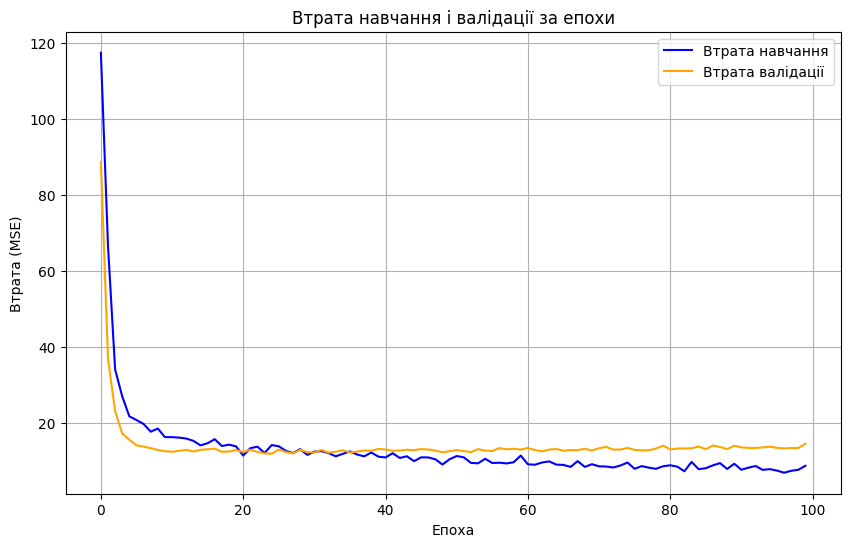

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Втрата навчання', color='blue')
plt.plot(history.history['val_loss'], label='Втрата валідації', color='orange')
plt.xlabel('Епоха')
plt.ylabel('Втрата (MSE)')
plt.title('Втрата навчання і валідації за епохи')
plt.legend()
plt.grid(True)
plt.show()


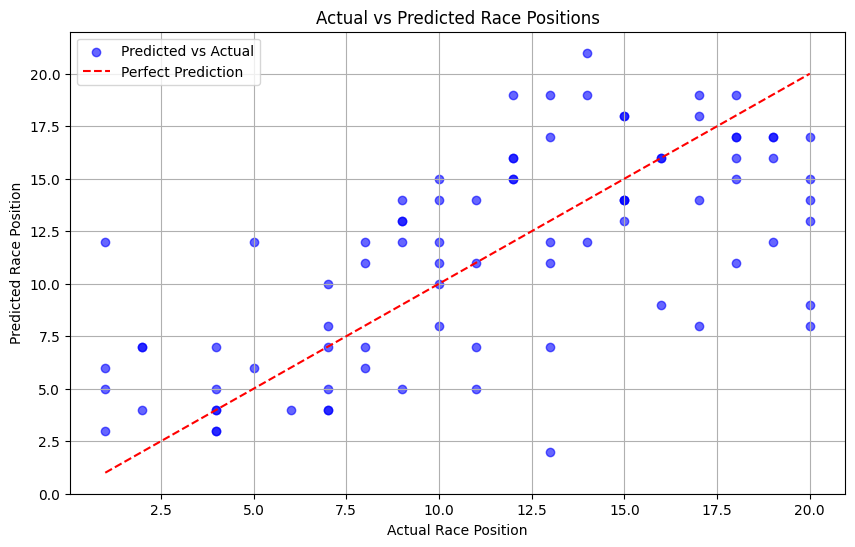

In [123]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted race positions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rounded, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Actual vs Predicted Race Positions')
plt.legend()
plt.grid(True)
plt.show()


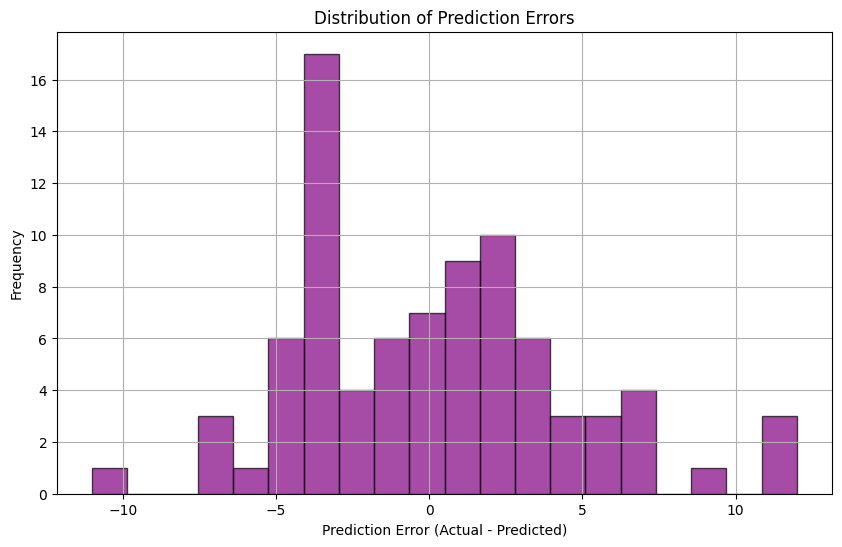

In [124]:
import numpy as np

# Calculate errors
errors = y_test - y_pred_rounded

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_51824/136971666.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  race_errors = data_2024.groupby('Race Round').apply(


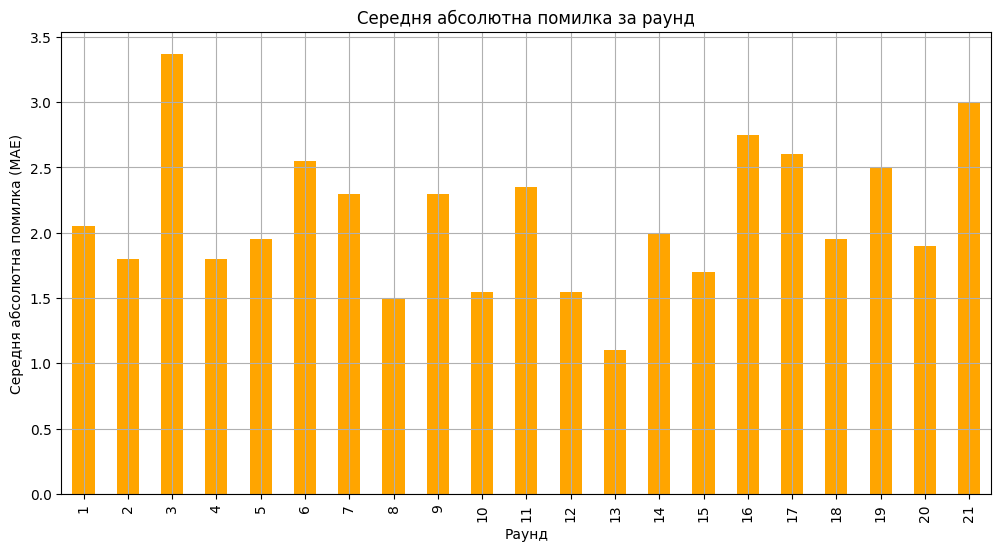

In [13]:
# Ensure that X is processed before predicting
X_full_processed = preprocessor.transform(X)  # Apply the preprocessing pipeline to X

# Predict race positions on the entire dataset
data_2024['Predicted Position'] = np.rint(model.predict(X_full_processed)).flatten()

# Calculate mean absolute error for each race round
race_errors = data_2024.groupby('Race Round').apply(
    lambda x: mean_absolute_error(x['Race Position'], x['Predicted Position'])
)

# Plot mean absolute error per race
plt.figure(figsize=(12, 6))
race_errors.plot(kind='bar', color='orange')
plt.xlabel('Раунд')
plt.ylabel('Середня абсолютна помилка (MAE)')
plt.title('Середня абсолютна помилка за раунд')
plt.grid(True)
plt.show()


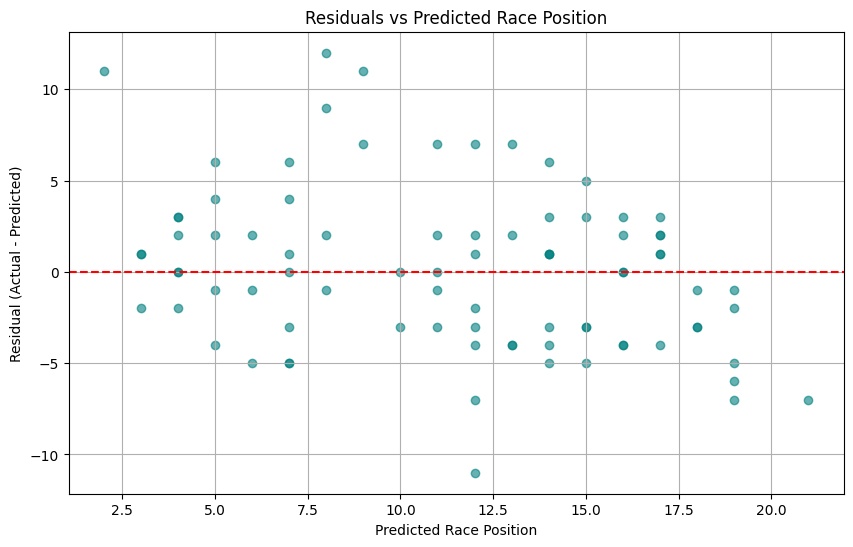

In [126]:
# Residuals vs predicted values
residuals = y_test - y_pred_rounded

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rounded, residuals, color='teal', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs Predicted Race Position')
plt.grid(True)
plt.show()


In [14]:
from keras.src.regularizers import L2

# Define an improved neural network model with L2 regularization
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.001)),
    Dense(1)  # Output layer to predict race position
])

# Compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/150


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131.3626 - mae: 9.9250 - val_loss: 108.0323 - val_mae: 8.6860
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.7714 - mae: 8.0600 - val_loss: 52.4741 - val_mae: 6.0496
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.4539 - mae: 5.3522 - val_loss: 27.0086 - val_mae: 4.1007
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.9727 - mae: 4.5248 - val_loss: 20.3838 - val_mae: 3.4995
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.4041 - mae: 4.0020 - val_loss: 16.3128 - val_mae: 3.0313
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.4514 - mae: 3.4686 - val_loss: 14.9421 - val_mae: 2.8775
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5965 - mae: 3.2332 - val_loss: 14.4622 - val_mae: 2.8503
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7899 - mae: 3.2239 - val_loss: 13.9788 - val_mae: 2.7920
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [128]:
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor

# Wrap the Keras model for scikit-learn cross-validation compatibility
def build_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# Wrap the model in KerasRegressor
model_cv = KerasRegressor(build_fn=build_model, epochs=100, batch_size=16, verbose=0)

# Perform k-fold cross-validation
kf = KFold(n_splits=5)
cv_results = cross_val_score(model_cv, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Print cross-validation results
print(f"Cross-Validation MAE Scores: {-cv_results}")
print(f"Mean Cross-Validation MAE: {-cv_results.mean():.2f}")


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core

Cross-Validation MAE Scores: [3.50779701 3.17135587 2.76874946 3.05489299 2.98599498]
Mean Cross-Validation MAE: 3.10


In [129]:
# Retrain the improved model on the full training set
history_improved = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred_improved = model.predict(X_test)
y_pred_improved_rounded = np.rint(y_pred_improved).flatten()

mae_improved = mean_absolute_error(y_test, y_pred_improved_rounded)
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved_rounded))

print(f"Improved Mean Absolute Error (MAE): {mae_improved:.2f}")
print(f"Improved Root Mean Squared Error (RMSE): {rmse_improved:.2f}")


Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4126 - mae: 1.1120 - val_loss: 16.3353 - val_mae: 2.8667
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3552 - mae: 1.0898 - val_loss: 16.7016 - val_mae: 2.8710
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8073 - mae: 1.2369 - val_loss: 17.2783 - val_mae: 3.0699
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5005 - mae: 1.1157 - val_loss: 17.1526 - val_mae: 2.9093
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7962 - mae: 1.1997 - val_loss: 16.8398 - val_mae: 2.9116
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0017 - mae: 1.2149 - val_loss: 17.5613 - val_mae: 2.9774
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7853 - mae: 1.1684 - val_loss: 17.0451 - val_mae: 3.0288
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4605 - mae: 1.2664 - val_loss: 16.8216 - val_mae: 2.9547
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

In [130]:
# Train the final model on the entire training set
history_final = model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=1)

# Evaluate on test data
y_pred_final = model.predict(X_test)
y_pred_final_rounded = np.rint(y_pred_final).flatten()

# Calculate final MAE and RMSE on test set
final_mae = mean_absolute_error(y_test, y_pred_final_rounded)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final_rounded))

print(f"Final Test Mean Absolute Error (MAE): {final_mae:.2f}")
print(f"Final Test Root Mean Squared Error (RMSE): {final_rmse:.2f}")

Epoch 1/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 5.8396 - mae: 1.2547
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 4.6228 - mae: 1.3671
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 2.9457 - mae: 1.1772
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 2.9608 - mae: 1.1272
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 3.1381 - mae: 1.1367
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 3.2823 - mae: 1.2072
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 3.3893 - mae: 1.2005
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 2.7458 - mae: 1.0820
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 2.7366 - mae: 1.1266
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 2.7982 - mae: 1.0782
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 2.7374 - mae: 1.1006
Epoch 12/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 3.0798 - mae: 1.1400
Epoch 13/150


In [131]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.regularizers import L2

# Step 1: Train the Neural Network Model
def build_neural_network():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train the neural network
nn_model = build_neural_network()
nn_model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=1)

# Neural network predictions
y_pred_nn_train = nn_model.predict(X_train).flatten()
y_pred_nn_test = nn_model.predict(X_test).flatten()

# Step 2: Train the Gradient Boosting Model
gb_model = HistGradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Gradient boosting predictions
y_pred_gb_train = gb_model.predict(X_train)
y_pred_gb_test = gb_model.predict(X_test)

# Step 3: Combine Predictions and Train Meta-Model
# Combine predictions for the meta-model
meta_train = np.column_stack((y_pred_nn_train, y_pred_gb_train))
meta_test = np.column_stack((y_pred_nn_test, y_pred_gb_test))

# Train a simple linear regression as the meta-model
meta_model = LinearRegression()
meta_model.fit(meta_train, y_train)

# Final ensemble predictions on the test set
y_pred_ensemble = meta_model.predict(meta_test)

# Evaluate the ensemble model
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print(f"Ensemble Model Mean Absolute Error (MAE): {mae_ensemble:.2f}")
print(f"Ensemble Model Root Mean Squared Error (RMSE): {rmse_ensemble:.2f}")


Epoch 1/150


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 111.0345 - mae: 8.8451 - val_loss: 59.4084 - val_mae: 6.4400
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.6868 - mae: 5.9535 - val_loss: 22.3801 - val_mae: 3.7710
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.3909 - mae: 3.8625 - val_loss: 15.9456 - val_mae: 2.9297
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6194 - mae: 3.3220 - val_loss: 15.2659 - val_mae: 2.8566
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0305 - mae: 3.2958 - val_loss: 13.4936 - val_mae: 2.7634
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1034 - mae: 3.0525 - val_loss: 13.6858 - val_mae: 2.8206
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.1434 - mae: 2.8577 - val_loss: 13.8690 - val_mae: 2.8053
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.5398 - mae: 2.6199 - val_loss: 13.9266 - val_mae: 2.8855
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

def build_nn_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),  # Increased neurons for more capacity
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

nn_model = KerasRegressor(
    model=build_nn_model,
    epochs=100,
    batch_size=16,
    verbose=0
)

# Define hyperparameter grid for the neural network
nn_param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [8, 16, 32, 64, 128],
    'epochs': [50, 100, 150, 200, 250, 300]
}

# Run RandomizedSearchCV for the neural network
nn_search = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=nn_param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error'
)
nn_search.fit(X_train, y_train)

# Best neural network parameters
print("Найкращі параметри нейронної мережі:", nn_search.best_params_)
best_nn_model = nn_search.best_estimator_

# Gradient Boosting model tuning
gb_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300, 400, 500],
}

gb_model = HistGradientBoostingRegressor()
gb_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error'
)
gb_search.fit(X_train, y_train)

# Best gradient boosting parameters
print("Найкращі параметри Gradient Boosting:", gb_search.best_params_)
best_gb_model = gb_search.best_estimator_

/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in

Найкращі параметри нейронної мережі: {'optimizer': 'adam', 'epochs': 300, 'batch_size': 8}
Найкращі параметри Gradient Boosting: {'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.01}


Epoch 1/300


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 70.8659 - mae: 6.8424 - val_loss: 21.5555 - val_mae: 3.4679
Epoch 2/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8881 - mae: 3.3945 - val_loss: 19.3245 - val_mae: 3.2576
Epoch 3/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.7674 - mae: 3.0969 - val_loss: 18.2224 - val_mae: 3.1773
Epoch 4/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9217 - mae: 3.1191 - val_loss: 19.1034 - val_mae: 3.2136
Epoch 5/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5621 - mae: 2.9025 - val_loss: 17.6442 - val_mae: 3.0680
Epoch 6/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.9014 - mae: 3.0584 - val_loss: 20.7879 - val_mae: 3.4272
Epoch 7/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9095 - mae: 2.6707 - val_loss: 17.2420 - val_mae: 3.0209
Epoch 8/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5841 - mae: 2.4352 - val_loss: 15.7139 - val_mae: 2.9551
Epoch 9/300
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1

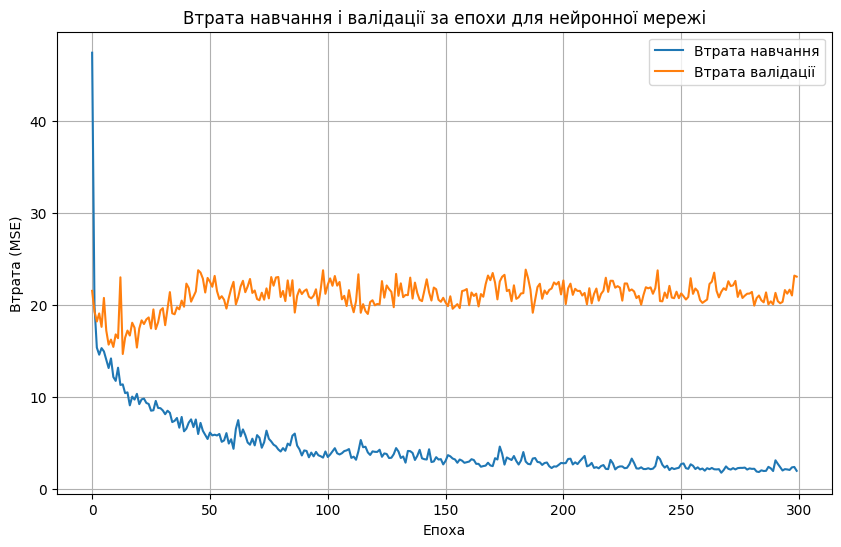

In [12]:
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.regularizers import L2


# Build the neural network with the best parameters
def build_best_nn_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the model
best_nn_model = build_best_nn_model()

# Track history for training and validation losses
history = best_nn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,  # using the best number of epochs
    batch_size=8,  # using the best batch size
    verbose=1
)

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Втрата навчання')
plt.plot(history.history['val_loss'], label='Втрата валідації')
plt.xlabel('Епоха')
plt.ylabel('Втрата (MSE)')
plt.title('Втрата навчання і валідації за епохи для нейронної мережі')
plt.legend()
plt.grid(True)
plt.show()


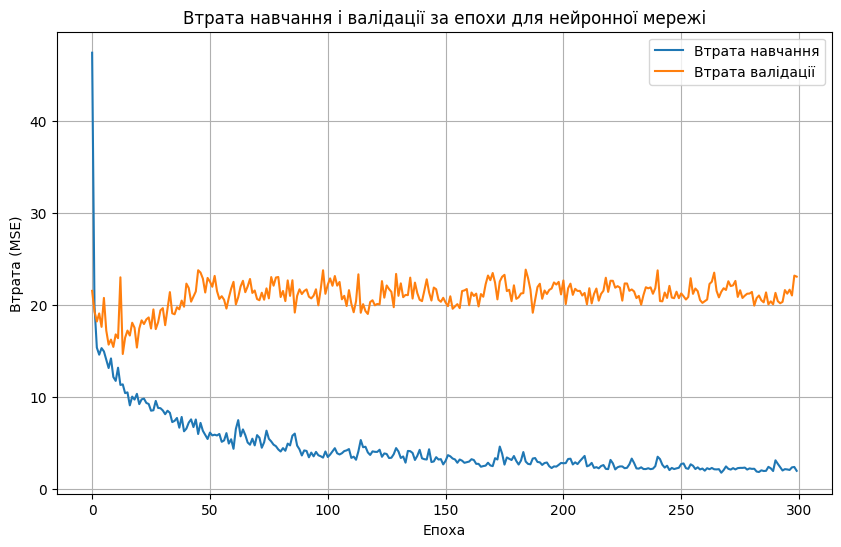

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Втрата навчання')
plt.plot(history.history['val_loss'], label='Втрата валідації')
plt.xlabel('Епоха')
plt.ylabel('Втрата (MSE)')
plt.title('Втрата навчання і валідації за епохи для нейронної мережі')
plt.legend()
plt.grid(True)
plt.show()

Gradient Boosting - Training MSE: 6.8051
Gradient Boosting - Validation MSE: 18.2091


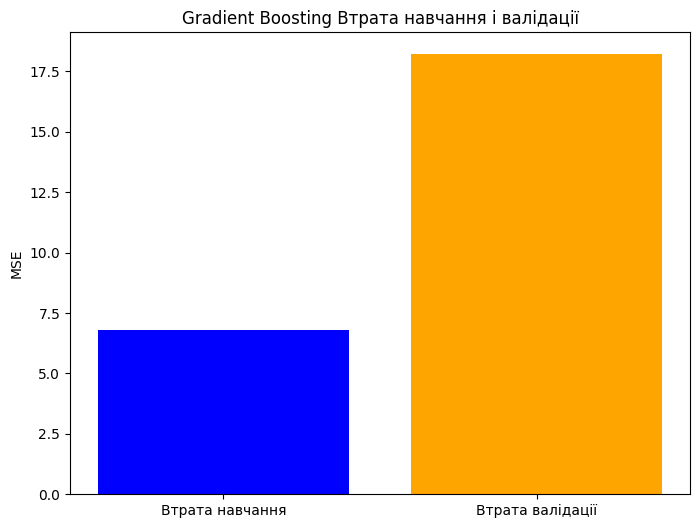

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit the best Gradient Boosting model with the best parameters
best_gb_model = HistGradientBoostingRegressor(max_iter=300, max_depth=10, learning_rate=0.01)
best_gb_model.fit(X_train, y_train)

# Calculate training and validation losses
gb_train_pred = best_gb_model.predict(X_train)
gb_val_pred = best_gb_model.predict(X_test)

train_mse = mean_squared_error(y_train, gb_train_pred)
val_mse = mean_squared_error(y_test, gb_val_pred)

# Display the errors
print(f"Gradient Boosting - Training MSE: {train_mse:.4f}")
print(f"Gradient Boosting - Validation MSE: {val_mse:.4f}")

# Bar plot for training and validation MSE for Gradient Boosting model
plt.figure(figsize=(8, 6))
plt.bar(['Втрата навчання', 'Втрата валідації'], [train_mse, val_mse], color=['blue', 'orange'])
plt.title('Gradient Boosting Втрата навчання і валідації')
plt.ylabel('MSE')
plt.show()



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Нейронна мережа:
Втрата навчання MAE: 0.5375
Втрата валідації MAE: 3.5540
Втрата навчання RMSE: 0.6791
Втрата валідації RMSE: 4.7295


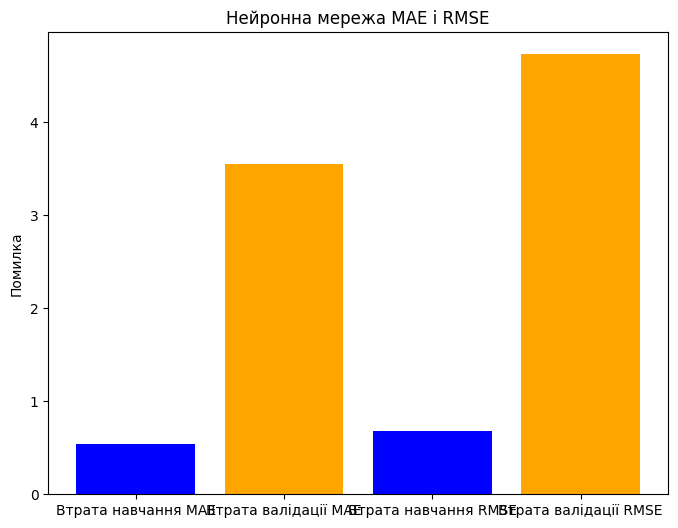


Gradient Boosting Model:
Втрата навчання MAE: 1.9168
Втрата валідації MAE: 3.3987
Втрата навчання RMSE: 2.6087
Втрата валідації RMSE: 4.2672


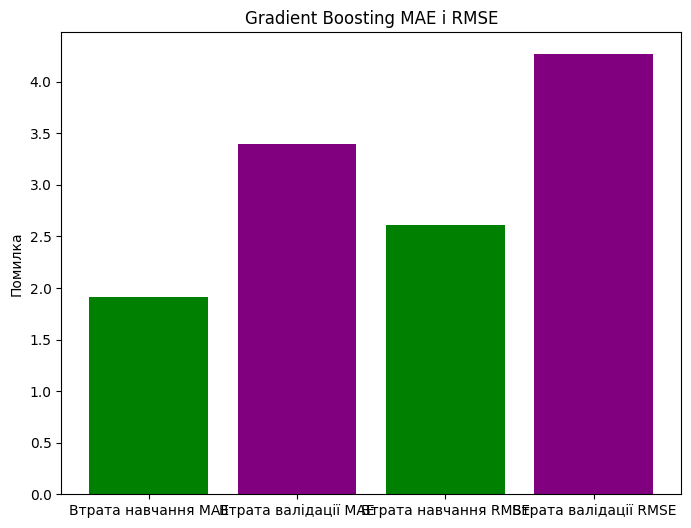

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Neural Network Model Evaluation
nn_train_pred = best_nn_model.predict(X_train).flatten()
nn_val_pred = best_nn_model.predict(X_test).flatten()

# Neural Network Metrics
nn_train_mae = mean_absolute_error(y_train, nn_train_pred)
nn_val_mae = mean_absolute_error(y_test, nn_val_pred)
nn_train_rmse = np.sqrt(mean_squared_error(y_train, nn_train_pred))
nn_val_rmse = np.sqrt(mean_squared_error(y_test, nn_val_pred))

print("Нейронна мережа:")
print(f"Втрата навчання MAE: {nn_train_mae:.4f}")
print(f"Втрата валідації MAE: {nn_val_mae:.4f}")
print(f"Втрата навчання RMSE: {nn_train_rmse:.4f}")
print(f"Втрата валідації RMSE: {nn_val_rmse:.4f}")

# Plotting Neural Network Metrics
plt.figure(figsize=(8, 6))
plt.bar(['Втрата навчання MAE', 'Втрата валідації MAE', 'Втрата навчання RMSE', 'Втрата валідації RMSE'],
        [nn_train_mae, nn_val_mae, nn_train_rmse, nn_val_rmse], color=['blue', 'orange', 'blue', 'orange'])
plt.title('Нейронна мережа MAE і RMSE')
plt.ylabel('Помилка')
plt.show()

# Gradient Boosting Model Evaluation
gb_train_pred = best_gb_model.predict(X_train)
gb_val_pred = best_gb_model.predict(X_test)

# Gradient Boosting Metrics
gb_train_mae = mean_absolute_error(y_train, gb_train_pred)
gb_val_mae = mean_absolute_error(y_test, gb_val_pred)
gb_train_rmse = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_val_rmse = np.sqrt(mean_squared_error(y_test, gb_val_pred))

print("\nGradient Boosting Model:")
print(f"Втрата навчання MAE: {gb_train_mae:.4f}")
print(f"Втрата валідації MAE: {gb_val_mae:.4f}")
print(f"Втрата навчання RMSE: {gb_train_rmse:.4f}")
print(f"Втрата валідації RMSE: {gb_val_rmse:.4f}")

# Plotting Gradient Boosting Metrics
plt.figure(figsize=(8, 6))
plt.bar(['Втрата навчання MAE', 'Втрата валідації MAE', 'Втрата навчання RMSE', 'Втрата валідації RMSE'],
        [gb_train_mae, gb_val_mae, gb_train_rmse, gb_val_rmse], color=['green', 'purple', 'green', 'purple'])
plt.title('Gradient Boosting MAE і RMSE')
plt.ylabel('Помилка')
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


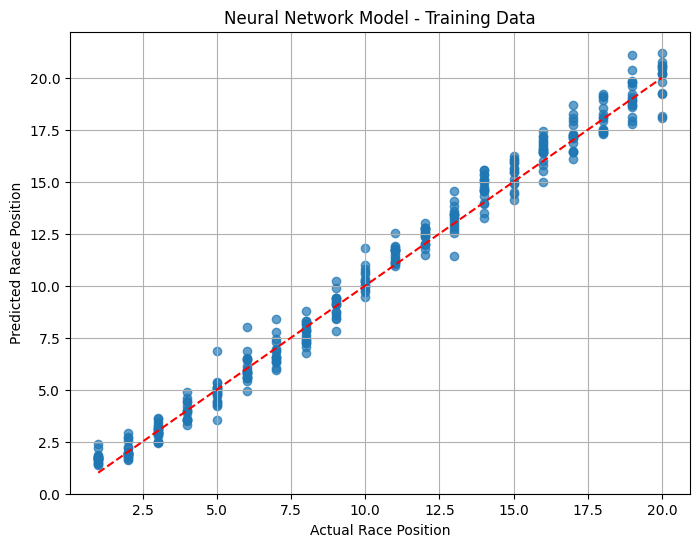

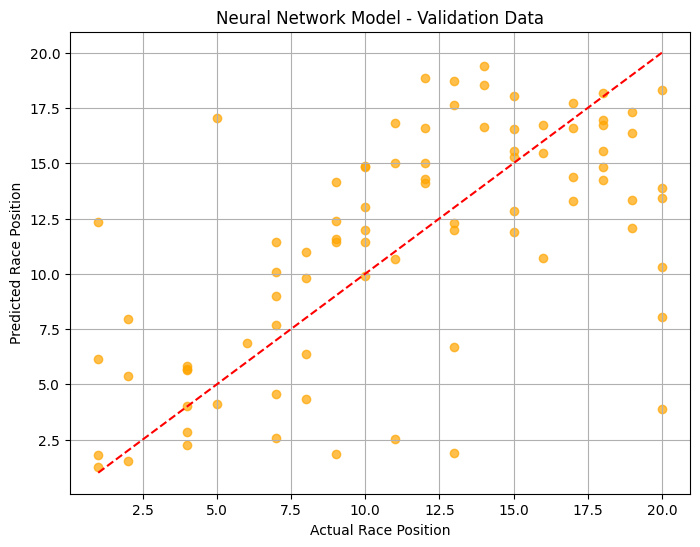

In [30]:
# Predict on training and validation data
nn_train_pred = best_nn_model.predict(X_train)
nn_val_pred = best_nn_model.predict(X_test)

# Plot for training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, nn_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Neural Network Model - Training Data')
plt.grid(True)
plt.show()

# Plot for validation data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, nn_val_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Neural Network Model - Validation Data')
plt.grid(True)
plt.show()


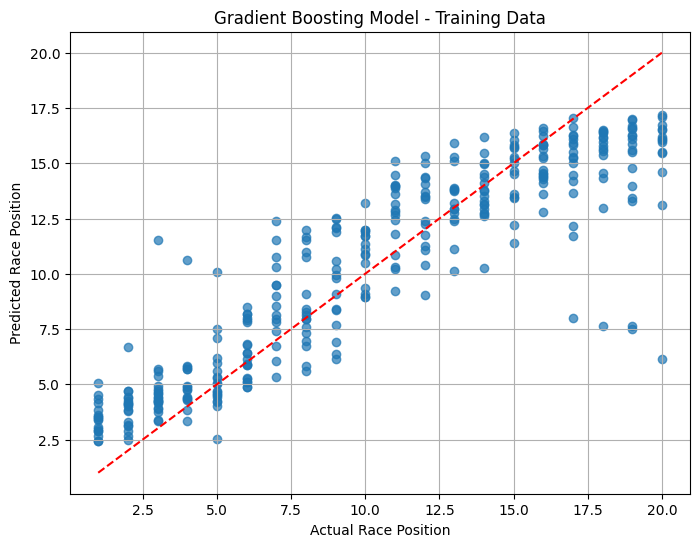

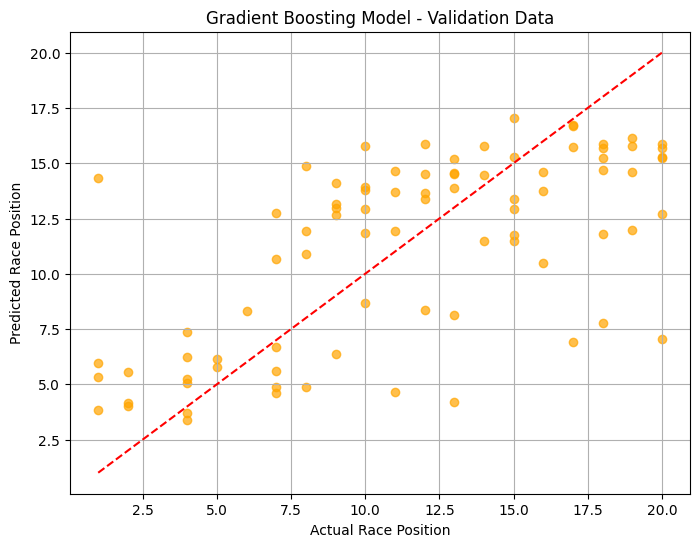

In [31]:
# Predict on training and validation data
gb_train_pred = best_gb_model.predict(X_train)
gb_val_pred = best_gb_model.predict(X_test)

# Plot for training data
plt.figure(figsize=(8, 6))
plt.scatter(y_train, gb_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Gradient Boosting Model - Training Data')
plt.grid(True)
plt.show()

# Plot for validation data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gb_val_pred, alpha=0.7, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Gradient Boosting Model - Validation Data')
plt.grid(True)
plt.show()


In [32]:
# Calculate residuals
nn_train_residuals = y_train - nn_train_pred
nn_val_residuals = y_test - nn_val_pred

# Plot residuals for training data
plt.figure(figsize=(8, 6))
plt.scatter(nn_train_pred, nn_train_residuals, alpha=0.7)
plt.hlines(y=0, xmin=nn_train_pred.min(), xmax=nn_train_pred.max(), colors='r')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.title('Neural Network Model - Residuals (Training Data)')
plt.grid(True)
plt.show()

# Plot residuals for validation data
plt.figure(figsize=(8, 6))
plt.scatter(nn_val_pred, nn_val_residuals, alpha=0.7, color='orange')
plt.hlines(y=0, xmin=nn_val_pred.min(), xmax=nn_val_pred.max(), colors='r')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.title('Neural Network Model - Residuals (Validation Data)')
plt.grid(True)
plt.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (335, 335) instead

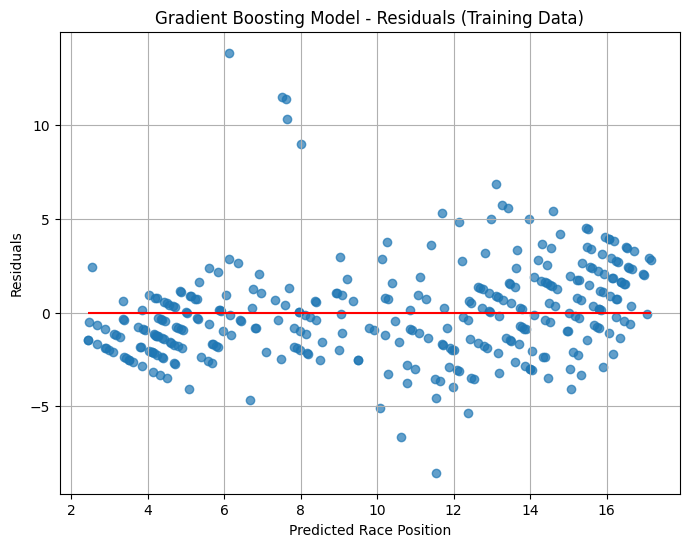

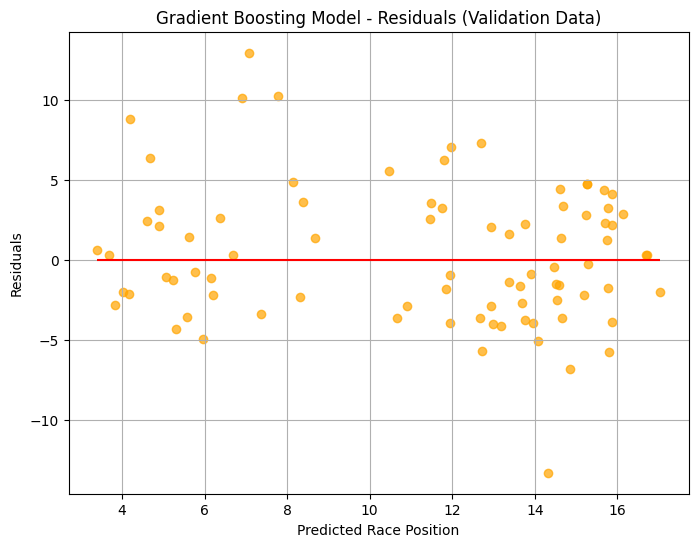

In [19]:
# Calculate residuals
gb_train_residuals = y_train - gb_train_pred
gb_val_residuals = y_test - gb_val_pred

# Plot residuals for training data
plt.figure(figsize=(8, 6))
plt.scatter(gb_train_pred, gb_train_residuals, alpha=0.7)
plt.hlines(y=0, xmin=gb_train_pred.min(), xmax=gb_train_pred.max(), colors='r')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.title('Gradient Boosting Model - Residuals (Training Data)')
plt.grid(True)
plt.show()

# Plot residuals for validation data
plt.figure(figsize=(8, 6))
plt.scatter(gb_val_pred, gb_val_residuals, alpha=0.7, color='orange')
plt.hlines(y=0, xmin=gb_val_pred.min(), xmax=gb_val_pred.max(), colors='r')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.title('Gradient Boosting Model - Residuals (Validation Data)')
plt.grid(True)
plt.show()


In [20]:
# Get feature names from the preprocessor
def get_feature_names(preprocessor):
    output_features = []

    # For each transformer in the ColumnTransformer
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(features)
        elif name == 'cat':
            # OneHotEncoder stores the categories in the 'onehot' step
            onehot = transformer.named_steps['onehot']
            categories = onehot.categories_[0]
            output_features.extend(categories)
    return output_features

feature_names = get_feature_names(preprocessor)


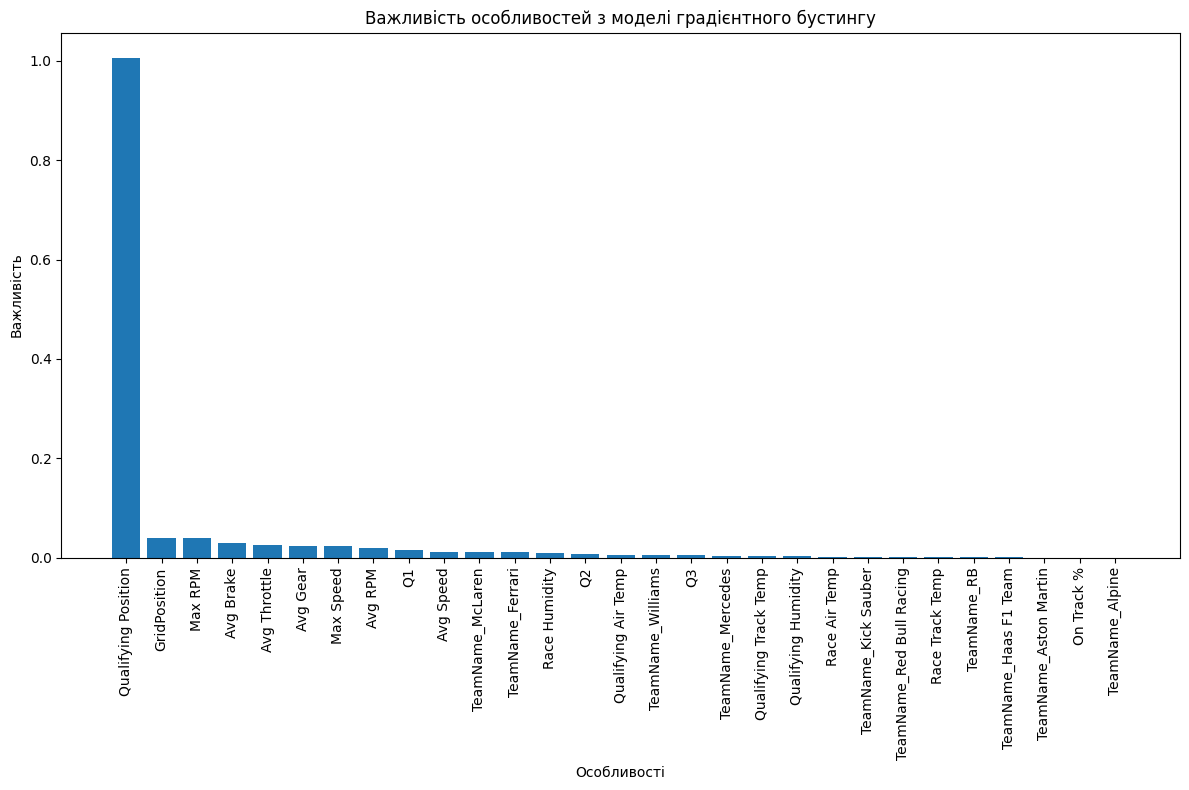

In [40]:
from sklearn.inspection import permutation_importance

# Compute permutation importances
result = permutation_importance(
    best_gb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Get feature names from the preprocessor
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(features)
        elif name == 'cat':
            # Get feature names from OneHotEncoder
            onehot = transformer.named_steps['onehot']
            categories = onehot.categories_
            cat_features = []
            for feature, cats in zip(features, categories):
                cat_features.extend([f"{feature}_{cat}" for cat in cats])
            output_features.extend(cat_features)
    return output_features

feature_names = get_feature_names(preprocessor)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title('Важливість особливостей з моделі градієнтного бустингу')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Особливості')
plt.ylabel('Важливість')
plt.tight_layout()
plt.show()


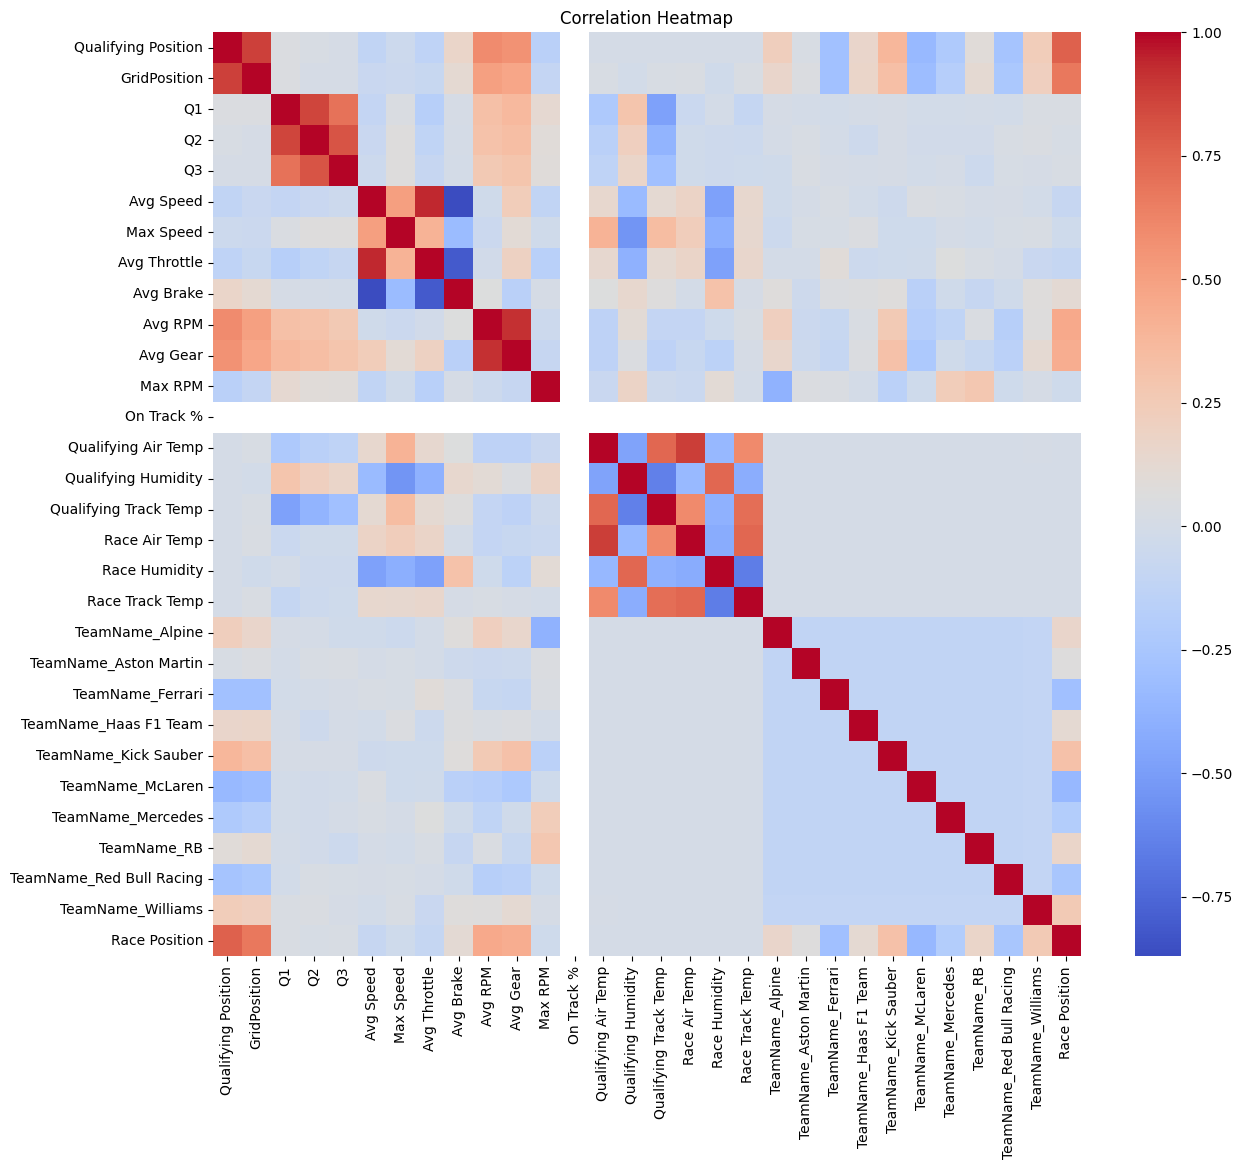

In [35]:
import seaborn as sns

# Get feature names from the preprocessor
feature_names = get_feature_names(preprocessor)

# Create DataFrame from preprocessed data
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Combine features and target for correlation
data_for_corr = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

# Calculate correlation matrix
corr_matrix = data_for_corr.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



[learning_curve] Training set sizes: [ 22  72 122 172 223]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished


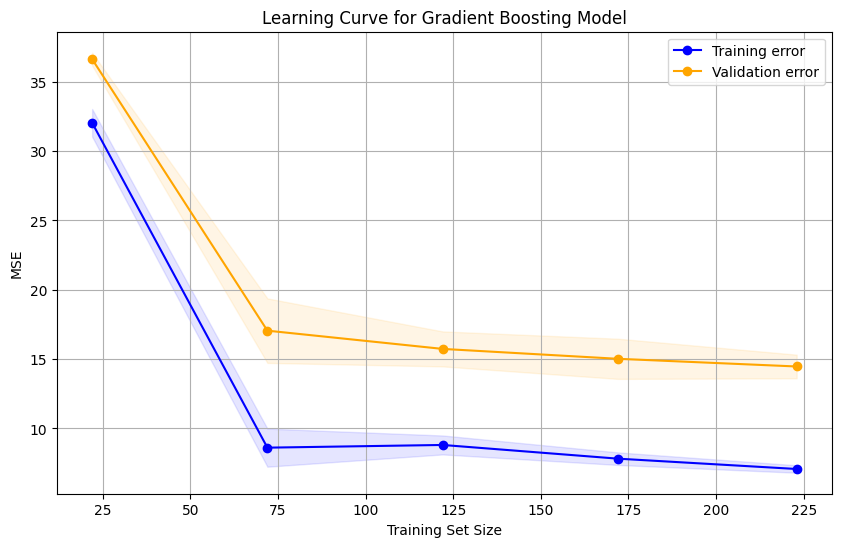

In [23]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_gb_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), verbose=1)

# Calculate mean and std
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training error')
plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Validation error')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve for Gradient Boosting Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [36]:
# Assuming you have 'Race Round' in your original data before splitting
# Create DataFrame from X (original features) to get 'Race Round'
X_df = X.reset_index(drop=True)

# Split data into training and testing sets with stratification to preserve indices
X_train_indices = X_train.index
X_test_indices = X_test.index

# Add 'Race Round' back to the training and testing data
X_train_original = X_df.loc[X_train_indices]
X_test_original = X_df.loc[X_test_indices]

X_train_original['Race Round'] = data_2024.loc[X_train_indices, 'Race Round'].values
X_test_original['Race Round'] = data_2024.loc[X_test_indices, 'Race Round'].values

# Calculate residuals for validation data
gb_val_residuals = y_test - gb_val_pred

# Combine residuals with Race Round
residuals_df = pd.DataFrame({
    'Race Round': X_test_original['Race Round'],
    'Residuals': gb_val_residuals
})

# Calculate mean absolute error per race round
mae_per_round = residuals_df.groupby('Race Round')['Residuals'].apply(lambda x: np.mean(np.abs(x)))

# Plot MAE per Race Round
plt.figure(figsize=(12, 6))
mae_per_round.plot(kind='bar')
plt.xlabel('Race Round')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error per Race Round')
plt.grid(True)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'index'

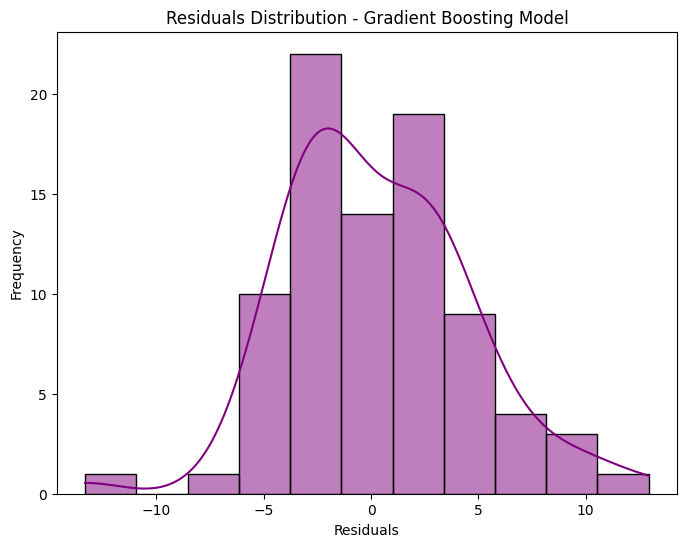

ValueError: Data must be 1-dimensional, got ndarray of shape (84, 84) instead

In [37]:
# Residual histogram for Gradient Boosting Model
plt.figure(figsize=(8, 6))
sns.histplot(gb_val_residuals, kde=True, color='purple')
plt.title('Residuals Distribution - Gradient Boosting Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residual histogram for Neural Network Model
# Ensure nn_val_residuals is calculated as in Error 1 fix
nn_val_residuals = y_test - nn_val_pred

# Residual histogram for Neural Network Model
plt.figure(figsize=(8, 6))
sns.histplot(nn_val_residuals, kde=True, color='orange')
plt.title('Residuals Distribution - Neural Network Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



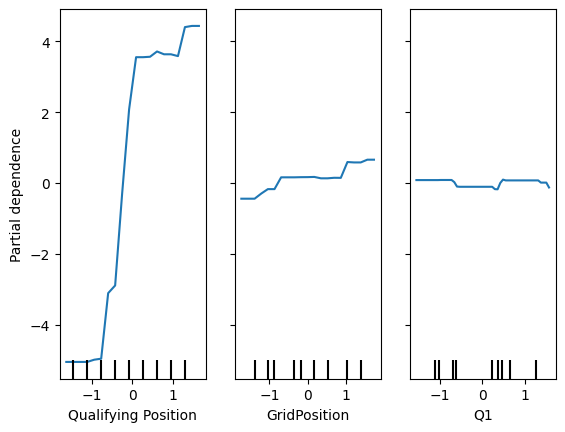

In [26]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [0, 1, 2]  # Indices of features you are interested in
PartialDependenceDisplay.from_estimator(best_gb_model, X_train, features_to_plot, feature_names=feature_names, grid_resolution=50)
plt.show()


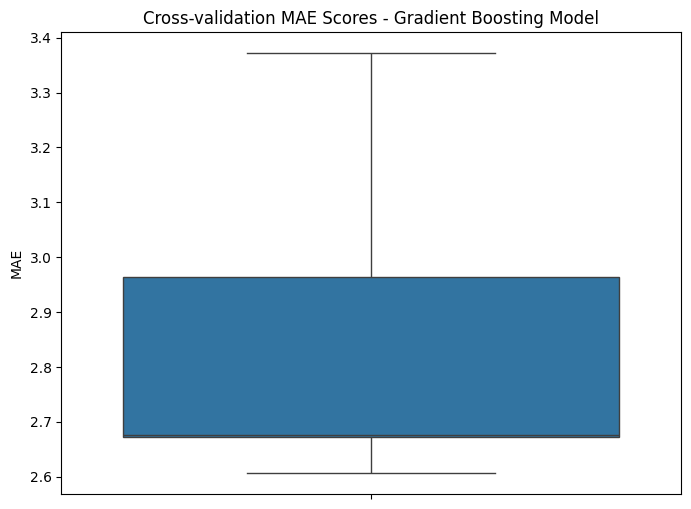

Mean MAE: 2.8579
Standard Deviation: 0.2850


In [27]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Gradient Boosting Model
cv_scores = cross_val_score(best_gb_model, X_processed, y, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive values
cv_scores = -cv_scores

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(data=cv_scores)
plt.title('Cross-validation MAE Scores - Gradient Boosting Model')
plt.ylabel('MAE')
plt.show()

print(f'Mean MAE: {cv_scores.mean():.4f}')
print(f'Standard Deviation: {cv_scores.std():.4f}')


In [38]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Predictions shape:", nn_train_pred.shape)


X_train shape: (335, 29)
y_train shape: (335,)
Predictions shape: (335, 1)


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the race session for a specific event in 2023
race_event = fastf1.get_event(2023, 1)  # Replace with desired race
race_session = fastf1.get_session(2023, race_event.RoundNumber, 'R')
race_session.load()
qualifying_session = fastf1.get_session(2023, race_event.RoundNumber, 'Q')
qualifying_session.load()
# Get list of laps
laps = race_session.laps

# Sort laps by time
laps = laps.sort_values(by='LapStartTime')



core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


In [49]:
# Get list of laps
laps = race_session.laps

# Sort laps by time
laps = laps.sort_values(by='LapStartTime')

laps.columns


Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [53]:
# Load qualifying session
qualifying_session = fastf1.get_session(2023, race_event.RoundNumber, 'Q')
qualifying_session.load()



core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.4.3]
req            INFO 	Updating cache for session_info...
_api           INFO 	Fetching session info data...
req            INFO 	Cache updated!
req            INFO 	Updating cache for driver_info...
_api           INFO 	Fetching driver list...
req            INFO 	Cache updated!
req            INFO 	Updating cache for session_status_data...
_api           INFO 	Fetching session status data...
req            INFO 	Cache updated!
req            INFO 	Updating cache for track_status_data...
_api           INFO 	Fetching track status data...
req            INFO 	Cache updated!
req            INFO 	Updating cache for _extended_timing_data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Cache updated!
req            INFO 	Updating cache for timing_app_data...
_api           INFO 	Fetching timing app data...
req            INFO 	Cache updated!
core    

In [73]:
def assign_default_values(df, features):
    for feature in features:
        if feature not in df.columns:
            # Assign appropriate default values
            if feature in ['Q1', 'Q2', 'Q3']:
                df[feature] = 999  # High value indicating no time set
            elif feature == 'On Track %':
                df[feature] = 100
            elif 'Qualifying' in feature:
                # Use values from current weather data or assign defaults
                if 'Air Temp' in feature:
                    df[feature] = df['AirTemp'] if 'AirTemp' in df.columns else 25
                elif 'Humidity' in feature:
                    df[feature] = df['Humidity'] if 'Humidity' in df.columns else 50
                elif 'Track Temp' in feature:
                    df[feature] = df['TrackTemp'] if 'TrackTemp' in df.columns else 30
            elif 'Race' in feature:
                # Use current race conditions
                if 'Air Temp' in feature:
                    df[feature] = df['AirTemp'] if 'AirTemp' in df.columns else 25
                elif 'Humidity' in feature:
                    df[feature] = df['Humidity'] if 'Humidity' in df.columns else 50
                elif 'Track Temp' in feature:
                    df[feature] = df['TrackTemp'] if 'TrackTemp' in df.columns else 30
            elif feature == 'Qualifying Position':
                df[feature] = 999  # Default high value indicating no qualifying position
            else:
                df[feature] = 0  # Default value for other features
    return df


# Initialize a DataFrame to store predictions
real_time_predictions = pd.DataFrame()

# Loop through each lap to simulate real-time data
for lap_number in range(1, int(laps['LapNumber'].max()) + 1):
    print(f"Processing Lap {lap_number}")

    # Get data up to the current lap
    current_laps = laps.pick_laps(range(1, lap_number + 1))

    # Get the last lap for each driver (current position)
    last_laps = current_laps.groupby('Driver').tail(1).reset_index(drop=True)

    # Get current positions based on last laps
    current_positions = last_laps[['Driver', 'Position', 'LapNumber']].copy()
    current_positions.rename(columns={'Position': 'Current Position'}, inplace=True)

    # Get average lap times for each driver
    avg_lap_times = current_laps.groupby('Driver')['LapTime'].mean().dt.total_seconds().reset_index()
    avg_lap_times.rename(columns={'LapTime': 'Avg Lap Time'}, inplace=True)

    # Merge current positions and average lap times
    current_data = pd.merge(current_positions, avg_lap_times, on='Driver')

    # Get driver info
    drivers_info = race_session.results[['Abbreviation', 'TeamName', 'DriverNumber']]
    current_data = pd.merge(current_data, drivers_info, left_on='Driver', right_on='Abbreviation', how='left')

    # Get grid positions
    grid_positions = race_session.results.set_index('Abbreviation')['GridPosition']
    current_data['GridPosition'] = current_data['Abbreviation'].map(grid_positions)

    # Get weather data for the current laps
    weather_data = current_laps.get_weather_data()
    weather_data = weather_data.reset_index(drop=True)

    # Merge weather data
    current_data = pd.concat([current_data.reset_index(drop=True), weather_data], axis=1)

    # Initialize a list to collect telemetry data for each driver
    telemetry_data_list = []

    # Iterate over each driver to get their telemetry data
    for driver in current_laps['Driver'].unique():
        driver_laps = current_laps.pick_drivers(driver)
        try:
            # Get car data for the driver
            car_data = driver_laps.get_car_data()
            # Check if car_data is empty
            if car_data.empty:
                raise ValueError("No telemetry data available.")

            # Aggregate telemetry data per driver
            telemetry_agg = car_data.agg({
                'Speed': ['mean', 'max'],
                'Throttle': 'mean',
                'Brake': 'mean',
                'RPM': ['mean', 'max'],
                'nGear': 'mean'
            })

            # Flatten the MultiIndex columns
            telemetry_agg.columns = ['_'.join(col).strip() for col in telemetry_agg.columns.values]

            # Rename the columns appropriately
            telemetry_agg.rename(columns={
                'Speed_mean': 'Avg Speed',
                'Speed_max': 'Max Speed',
                'Throttle_mean': 'Avg Throttle',
                'Brake_mean': 'Avg Brake',
                'RPM_mean': 'Avg RPM',
                'RPM_max': 'Max RPM',
                'nGear_mean': 'Avg Gear'
            }, inplace=True)

            # Reset index to convert DataFrame from 1-row DataFrame to Series
            telemetry_agg.reset_index(drop=True, inplace=True)

            # Add the driver column
            telemetry_agg['Driver'] = driver

            telemetry_data_list.append(telemetry_agg)
        except Exception as e:
            print(f"Could not get telemetry data for driver {driver}: {e}")
            # Create a DataFrame with zero or default values
            empty_telemetry = pd.DataFrame({
                'Avg Speed': [0],
                'Max Speed': [0],
                'Avg Throttle': [0],
                'Avg Brake': [0],
                'Avg RPM': [0],
                'Max RPM': [0],
                'Avg Gear': [0],
                'Driver': [driver]
            })
            telemetry_data_list.append(empty_telemetry)

    # Concatenate telemetry data for all drivers
    telemetry_data = pd.concat(telemetry_data_list, ignore_index=True)

    # Merge telemetry data
    current_data = pd.merge(current_data, telemetry_data, on='Driver', how='left')

    # Ensure 'Abbreviation' is in current_data
    if 'Abbreviation' not in current_data.columns:
        current_data['Abbreviation'] = current_data['Driver']

   # Get qualifying results
    qualifying_results = qualifying_session.results[['Abbreviation', 'Position']]

    # Rename 'Position' to 'Qualifying Position'
    qualifying_results = qualifying_results.rename(columns={'Position': 'Qualifying Position'})

    # Merge qualifying results
    current_data = pd.merge(current_data, qualifying_results, on='Abbreviation', how='left')

    # Fill missing qualifying positions
    current_data['Qualifying Position'] = current_data['Qualifying Position'].fillna(999)

    # Fill missing telemetry data with zeros
    current_data.fillna(0, inplace=True)

    # Prepare required features (adjust as necessary)
    required_features = [
        'Qualifying Position',
        'GridPosition',
        'Avg Lap Time',
        'Avg Speed',
        'Max Speed',
        'Avg Throttle',
        'Avg Brake',
        'Avg RPM',
        'Avg Gear',
        'Max RPM',
        'AirTemp',
        'Humidity',
        'TrackTemp',
        'TeamName',
        'Q1',
        'Q2',
        'Q3',
        'On Track %',
        'Qualifying Air Temp',
        'Qualifying Humidity',
        'Qualifying Track Temp',
        'Race Air Temp',
        'Race Humidity',
        'Race Track Temp'
    ]

    # Assign default values to missing features
    current_data = assign_default_values(current_data, required_features)

    # Select required features
    X_real_time = current_data[required_features]

    # Ensure correct data types
    numerical_features = X_real_time.select_dtypes(include=['float64', 'int64']).columns
    X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)

    # Preprocess the data using the preprocessor from training
    X_real_time_processed = preprocessor.transform(X_real_time)

    # Make predictions
    nn_predictions = best_nn_model.predict(X_real_time_processed).flatten()
    gb_predictions = best_gb_model.predict(X_real_time_processed)

    # Store predictions
    current_data['NN Predicted Position'] = nn_predictions
    current_data['GB Predicted Position'] = gb_predictions

    # Add lap number
    current_data['LapNumber'] = lap_number

    # Append to real-time predictions DataFrame
    real_time_predictions = pd.concat([real_time_predictions, current_data], ignore_index=True)

Processing Lap 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing Lap 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Processing Lap 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
Processing Lap 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
Processing Lap 6
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 7
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
Processing Lap 8
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 9
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
Processing Lap 10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 11
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
Processing Lap 12
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 13
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Processing Lap 14
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
Processing Lap 16


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
Processing Lap 17
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
Processing Lap 18
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
Processing Lap 19


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
Processing Lap 20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
Processing Lap 21


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Processing Lap 22
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
Processing Lap 23
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is d

Processing Lap 24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
Processing Lap 25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 26
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 27
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 28
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 29
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 31
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 32
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 33
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 34
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 35
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 37
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 38
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 39
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 41
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 42
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 43
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 44
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 45
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 46
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 47
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 48
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 49
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 51
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 52
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 53
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 54
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 55
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 56
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


Processing Lap 57
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  current_data.fillna(0, inplace=True)
/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_3299/1286178133.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_real_time[numerical_features] = X_real_time[numerical_features].astype(float)


In [74]:
print(real_time_predictions.head())


  Driver  Current Position  LapNumber  Avg Lap Time Abbreviation  \
0    VER               1.0          1        99.019          VER   
1    VER               1.0          1        99.019          VER   
2    RUS               6.0          1       102.662          RUS   
3    RUS               6.0          1       102.662          RUS   
4    GAS              19.0          1       109.649          GAS   

          TeamName DriverNumber  GridPosition                    Time AirTemp  \
0  Red Bull Racing            1           1.0  0 days 01:02:45.730000    27.3   
1  Red Bull Racing            1           1.0  0 days 01:02:45.730000    27.3   
2         Mercedes           63           6.0  0 days 01:02:45.730000    27.3   
3         Mercedes           63           6.0  0 days 01:02:45.730000    27.3   
4           Alpine           10          20.0  0 days 01:02:45.730000    27.3   

   ...   Q3 On Track % Qualifying Air Temp Qualifying Humidity  \
0  ...  999        100                

In [75]:
# Group by LapNumber and Driver
grouped_predictions = real_time_predictions.groupby(['LapNumber', 'Driver']).agg({
    'NN Predicted Position': 'first',
    'GB Predicted Position': 'first'
}).reset_index()


In [76]:
# For each lap, sort drivers by predicted positions
def get_sorted_predictions(model_name):
    sorted_predictions = []
    for lap in sorted(grouped_predictions['LapNumber'].unique()):
        lap_data = grouped_predictions[grouped_predictions['LapNumber'] == lap]
        lap_data = lap_data.sort_values(by=f'{model_name} Predicted Position')
        lap_data['Predicted Rank'] = range(1, len(lap_data) + 1)
        lap_data['LapNumber'] = lap
        sorted_predictions.append(lap_data)
    return pd.concat(sorted_predictions, ignore_index=True)

# Get sorted predictions for both models
nn_sorted_predictions = get_sorted_predictions('NN')
gb_sorted_predictions = get_sorted_predictions('GB')


In [77]:
# Get the final lap number
final_lap = real_time_predictions['LapNumber'].max()

# Get predictions for the final lap
nn_final_predictions = nn_sorted_predictions[nn_sorted_predictions['LapNumber'] == final_lap]
gb_final_predictions = gb_sorted_predictions[gb_sorted_predictions['LapNumber'] == final_lap]

# Display the predictions
print("Neural Network Predictions for Final Lap:")
print(nn_final_predictions[['Driver', 'NN Predicted Position', 'Predicted Rank']])

print("\nGradient Boosting Predictions for Final Lap:")
print(gb_final_predictions[['Driver', 'GB Predicted Position', 'Predicted Rank']])


Neural Network Predictions for Final Lap:
     Driver  NN Predicted Position  Predicted Rank
1175    LEC              11.690157               1
1176    VER              11.698604               2
1177    SAI              11.713895               3
1178    PER              11.721802               4
1179    RUS              11.849631               5
1180    HAM              11.873075               6
1181    OCO              11.890689               7
1182    ALO              11.912234               8
1183    NOR              11.930589               9
1184    HUL              11.968852              10
1185    STR              11.986608              11
1186    BOT              12.029660              12
1187    ZHO              12.052587              13
1188    TSU              12.075513              14
1189    PIA              12.112326              15
1190    ALB              12.125586              16
1191    MAG              12.144618              17
1192    SAR              12.148562      

In [ ]:
import matplotlib.pyplot as plt

# Function to plot predictions over laps for a driver
def plot_driver_predictions(driver):
    plt.figure(figsize=(12, 6))

    # Plot NN predictions
    nn_driver_data = nn_sorted_predictions[nn_sorted_predictions['Driver'] == driver]
    plt.plot(nn_driver_data['LapNumber'], nn_driver_data['Predicted Rank'], label='NN Predicted Rank', marker='o')

    # Plot GB predictions
    gb_driver_data = gb_sorted_predictions[gb_sorted_predictions['Driver'] == driver]
    plt.plot(gb_driver_data['LapNumber'], gb_driver_data['Predicted Rank'], label='GB Predicted Rank', marker='x')

    # Actual positions (assuming 'Current Position' reflects actual position)
    actual_data = real_time_predictions[real_time_predictions['Driver'] == driver]
    plt.plot(actual_data['LapNumber'], actual_data['Current Position'], label='Actual Position', linestyle='--')

    plt.gca().invert_yaxis()  # Lower ranks (positions) at the top
    plt.xlabel('Lap Number')
    plt.ylabel('Position')
    plt.title(f'Predicted Positions Over Laps for {driver}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions for a specific driver
plot_driver_predictions('VER')  # Replace 'VER' with the driver's abbreviation you're interested in


In [ ]:
# Get the list of drivers
drivers = real_time_predictions['Driver'].unique()

# Plot predictions for each driver
for driver in drivers:
    plot_driver_predictions(driver)


In [81]:
# Get actual final positions
final_positions = real_time_predictions[real_time_predictions['LapNumber'] == final_lap][['Driver', 'Current Position']]

# Merge with predictions
nn_final_predictions = nn_final_predictions.merge(final_positions, on='Driver')
gb_final_predictions = gb_final_predictions.merge(final_positions, on='Driver')


In [82]:
print("Neural Network Final Predictions vs Actual Positions:")
print(nn_final_predictions[['Driver', 'NN Predicted Position', 'Predicted Rank', 'Current Position']])

print("\nGradient Boosting Final Predictions vs Actual Positions:")
print(gb_final_predictions[['Driver', 'GB Predicted Position', 'Predicted Rank', 'Current Position']])


Neural Network Final Predictions vs Actual Positions:
     Driver  NN Predicted Position  Predicted Rank  Current Position
0       LEC              11.690157               1               0.0
1       LEC              11.690157               1               0.0
2       VER              11.698604               2               1.0
3       VER              11.698604               2               1.0
4       SAI              11.713895               3               4.0
...     ...                    ...             ...               ...
1071      0             188.470184              21               0.0
1072      0             188.470184              21               0.0
1073      0             188.470184              21               0.0
1074      0             188.470184              21               0.0
1075      0             188.470184              21               0.0

[1076 rows x 4 columns]

Gradient Boosting Final Predictions vs Actual Positions:
     Driver  GB Predicted Position 

In [83]:
# Calculate the difference between predicted rank and actual position
nn_final_predictions['NN Error'] = nn_final_predictions['Predicted Rank'] - nn_final_predictions['Current Position']
gb_final_predictions['GB Error'] = gb_final_predictions['Predicted Rank'] - gb_final_predictions['Current Position']

# Display the errors
print("Neural Network Prediction Errors:")
print(nn_final_predictions[['Driver', 'Predicted Rank', 'Current Position', 'NN Error']])

print("\nGradient Boosting Prediction Errors:")
print(gb_final_predictions[['Driver', 'Predicted Rank', 'Current Position', 'GB Error']])


Neural Network Prediction Errors:
     Driver  Predicted Rank  Current Position  NN Error
0       LEC               1               0.0       1.0
1       LEC               1               0.0       1.0
2       VER               2               1.0       1.0
3       VER               2               1.0       1.0
4       SAI               3               4.0      -1.0
...     ...             ...               ...       ...
1071      0              21               0.0      21.0
1072      0              21               0.0      21.0
1073      0              21               0.0      21.0
1074      0              21               0.0      21.0
1075      0              21               0.0      21.0

[1076 rows x 4 columns]

Gradient Boosting Prediction Errors:
     Driver  Predicted Rank  Current Position  GB Error
0       SAI               1               4.0      -3.0
1       SAI               1               4.0      -3.0
2       LEC               2               0.0       2.0
3      

In [84]:
from sklearn.metrics import mean_absolute_error

# Neural Network MAE
nn_mae = mean_absolute_error(nn_final_predictions['Current Position'], nn_final_predictions['Predicted Rank'])
print(f"Neural Network Mean Absolute Error: {nn_mae:.2f}")

# Gradient Boosting MAE
gb_mae = mean_absolute_error(gb_final_predictions['Current Position'], gb_final_predictions['Predicted Rank'])
print(f"Gradient Boosting Mean Absolute Error: {gb_mae:.2f}")


Neural Network Mean Absolute Error: 20.38
Gradient Boosting Mean Absolute Error: 18.44


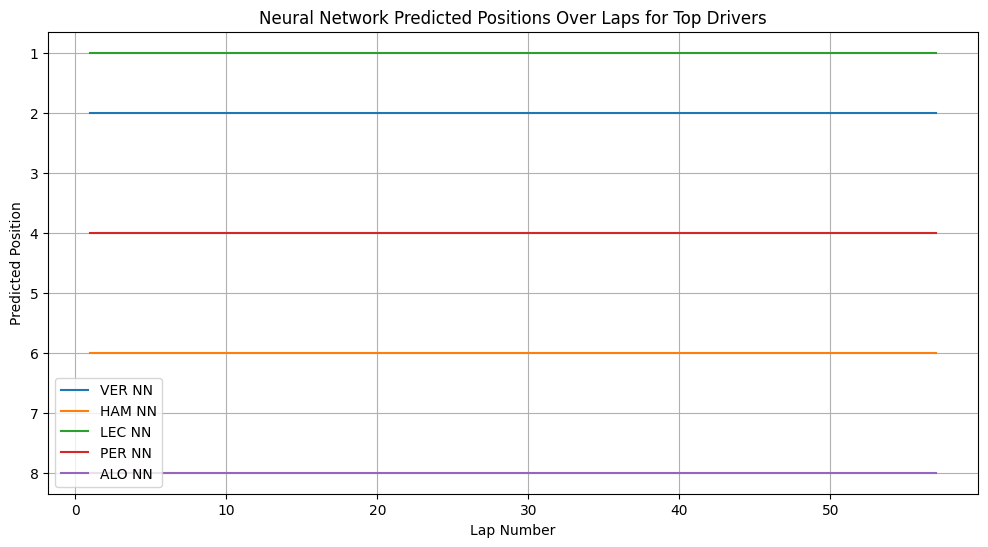

In [85]:
# Plot predictions for top drivers
top_drivers = ['VER', 'HAM', 'LEC', 'PER', 'ALO']  # Replace with desired drivers

plt.figure(figsize=(12, 6))

for driver in top_drivers:
    nn_driver_data = nn_sorted_predictions[nn_sorted_predictions['Driver'] == driver]
    plt.plot(nn_driver_data['LapNumber'], nn_driver_data['Predicted Rank'], label=f'{driver} NN')

plt.gca().invert_yaxis()
plt.xlabel('Lap Number')
plt.ylabel('Predicted Position')
plt.title('Neural Network Predicted Positions Over Laps for Top Drivers')
plt.legend()
plt.grid(True)
plt.show()


In [134]:
# Weighted averaging of predictions (e.g., 70% NN and 30% GB)
y_pred_weighted = 0.7 * y_pred_nn_test + 0.3 * y_pred_gb_test

# Evaluate the weighted ensemble
mae_weighted = mean_absolute_error(y_test, y_pred_weighted)
rmse_weighted = np.sqrt(mean_squared_error(y_test, y_pred_weighted))

print(f"Weighted Ensemble Model Mean Absolute Error (MAE): {mae_weighted:.2f}")
print(f"Weighted Ensemble Model Root Mean Squared Error (RMSE): {rmse_weighted:.2f}")


Weighted Ensemble Model Mean Absolute Error (MAE): 3.17
Weighted Ensemble Model Root Mean Squared Error (RMSE): 4.12


In [135]:
import tensorflow as tf
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.regularizers import L2

# Define the final neural network model with optimized parameters
def build_final_nn_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(32, activation='relu', kernel_regularizer=L2(0.001)),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Train the final neural network model
finalModelNeural = build_final_nn_model()
finalModelNeural.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Save the neural network model
finalModelNeural.save('finalModelNeuralv2.h5')
print("finalModelNeuralv2 has been saved as 'finalModelNeuralv2.h5'")


Epoch 1/50


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 97.2624 - mae: 8.1469 - val_loss: 22.6190 - val_mae: 3.7682
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0340 - mae: 3.9370 - val_loss: 16.1123 - val_mae: 3.0330
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9574 - mae: 3.3486 - val_loss: 13.8700 - val_mae: 2.8043
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8777 - mae: 3.0756 - val_loss: 12.5732 - val_mae: 2.7341
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3853 - mae: 2.9715 - val_loss: 13.6785 - val_mae: 2.9171
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.3580 - mae: 2.7514 - val_loss: 13.4479 - val_mae: 2.8736
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.8029 - mae: 2.8562 - val_loss: 14.0183 - val_mae: 2.8951
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.0101 - mae: 2.7774 - val_loss: 14.6348 - val_mae: 3.1465
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9763 -

finalModelNeuralv2 has been saved as 'finalModelNeuralv2.h5'


In [136]:
import pickle
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

# Train the optimized Gradient Boosting model
finalModelGB = HistGradientBoostingRegressor(max_iter=100, max_depth=3, learning_rate=0.1)
finalModelGB.fit(X_train, y_train)

# Generate predictions from the optimized models
y_pred_nn_train = finalModelNeural.predict(X_train).flatten()
y_pred_nn_test = finalModelNeural.predict(X_test).flatten()
y_pred_gb_train = finalModelGB.predict(X_train)
y_pred_gb_test = finalModelGB.predict(X_test)

# Apply weighted averaging to combine predictions (70% NN, 30% GB)
y_pred_weighted_train = 0.7 * y_pred_nn_train + 0.3 * y_pred_gb_train
y_pred_weighted_test = 0.7 * y_pred_nn_test + 0.3 * y_pred_gb_test

# Define a function to make weighted predictions for new data
def finalModelWeighted(X_new):
    nn_predictions = finalModelNeural.predict(X_new).flatten()
    gb_predictions = finalModelGB.predict(X_new)
    return 0.7 * nn_predictions + 0.3 * gb_predictions

# Save the weighted model using pickle
with open('finalModelWeighted.pkl', 'wb') as f:
    pickle.dump(finalModelWeighted, f)

print("finalModelWeighted has been saved as 'finalModelWeighted.pkl'")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
finalModelWeighted has been saved as 'finalModelWeighted.pkl'


In [138]:
from keras.src.saving import load_model
from keras.src.metrics import MeanSquaredError

# Load finalModelNeural with custom_objects specified
loaded_nn_model = load_model('finalModelNeuralv2.h5', custom_objects={'mse': MeanSquaredError})
print("finalModelNeural loaded successfully.")

# Load finalModelWeighted
import pickle
with open('finalModelWeighted.pkl', 'rb') as f:
    loaded_weighted_model = pickle.load(f)
print("finalModelWeighted loaded successfully.")

# Example of using loaded models for predictions
nn_predictions = loaded_nn_model.predict(X_test)
weighted_predictions = loaded_weighted_model(X_test)


finalModelNeural loaded successfully.
finalModelWeighted loaded successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


In [139]:
def collect_2019_1_data_with_features():
    all_data = []

    try:
        # Load qualifying session
        qual_session = fastf1.get_session(2019, 1, 'Q')
        qual_session.load()
        if qual_session.results.empty:
            print(f"Qualifying data not available for round 1. Skipping.")

        # Load race session
        race_session = fastf1.get_session(2019, 1, 'R')
        race_session.load()
        if race_session.results.empty:
            print(f"Race data not available for round 1. Skipping.")

        # Get position data (qualifying and race results)
        position_data = get_position_data(qual_session, race_session)

        # Get weather data for qualifying and race sessions
        qual_weather_data = get_weather_data(qual_session)
        race_weather_data = get_weather_data(race_session)

        # Get telemetry data
        telemetry_data = get_telemetry_data(qual_session)

        # Combine all data
        race_data = position_data.merge(telemetry_data, on='Abbreviation', how='left')

        # Add qualifying and race weather data to race_data
        for key, value in qual_weather_data.items():
            race_data[f'Qualifying {key}'] = value
        for key, value in race_weather_data.items():
            race_data[f'Race {key}'] = value

        # Add Race Round column
        race_data['Race Round'] = 1

        # Append data for the current round to all_data
        all_data.append(race_data)

    except Exception as e:
        print(f"Error processing round 1: {e}")

    # Concatenate all race data into a single DataFrame
    full_data = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

    return full_data

# Re-collect the data for 2024 with additional features and Race Round
data_2019_1 = collect_2019_1_data_with_features()
data_2019_1.head()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.4.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req   

,Abbreviation,Qualifying Position,TeamName,Q1,Q2,Q3,Race Position,GridPosition,Avg Speed,Max Speed,...,Avg Gear,Max RPM,On Track %,Qualifying Air Temp,Qualifying Humidity,Qualifying Track Temp,Race Air Temp,Race Humidity,Race Track Temp,Race Round
0,HAM,1.0,Mercedes,0 days 00:01:22.043000,0 days 00:01:21.014000,0 days 00:01:20.486000,2.0,1.0,236.632997,321,...,2.676919,12694,100.0,23.169231,69.102564,37.770513,23.477869,70.453279,41.313115,1
1,BOT,2.0,Mercedes,0 days 00:01:22.367000,0 days 00:01:21.193000,0 days 00:01:20.598000,1.0,2.0,235.846026,322,...,2.767104,12352,100.0,23.169231,69.102564,37.770513,23.477869,70.453279,41.313115,1
2,VET,3.0,Ferrari,0 days 00:01:22.885000,0 days 00:01:21.912000,0 days 00:01:21.190000,4.0,3.0,235.057661,318,...,2.286075,12515,100.0,23.169231,69.102564,37.770513,23.477869,70.453279,41.313115,1
3,VER,4.0,Red Bull Racing,0 days 00:01:22.876000,0 days 00:01:21.678000,0 days 00:01:21.320000,3.0,4.0,234.296900,320,...,2.357961,12200,100.0,23.169231,69.102564,37.770513,23.477869,70.453279,41.313115,1
4,LEC,5.0,Ferrari,0 days 00:01:22.017000,0 days 00:01:21.739000,0 days 00:01:21.442000,5.0,5.0,234.011438,321,...,2.445514,12205,100.0,23.169231,69.102564,37.770513,23.477869,70.453279,41.313115,1


In [140]:
# Assuming your new data for round 1 of 2019 is loaded in a DataFrame called `data_2019_round1`

# Convert Q1, Q2, and Q3 times from timedelta to seconds if necessary
data_2019_1['Q1'] = data_2019_1['Q1'].dt.total_seconds()
data_2019_1['Q2'] = data_2019_1['Q2'].dt.total_seconds()
data_2019_1['Q3'] = data_2019_1['Q3'].dt.total_seconds()

# Separate features (X) and target (y) in the 2019 data
X_2019_round1 = data_2019_1.drop(columns=['Abbreviation', 'Race Position'])
y_2019_round1 = data_2019_1['Race Position']

# Apply the same preprocessing pipeline used on the training data
X_2019_round1_processed = preprocessor.transform(X_2019_round1)


In [144]:
# Predict with finalModelNeural
nn_predictions_2019 = loaded_nn_model.predict(X_2019_round1_processed).flatten()

# Predict with finalModelWeighted
weighted_predictions_2019 = loaded_weighted_model(X_2019_round1_processed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [142]:
import numpy as np

# Assuming `predictions` is the array of model predictions
def enforce_integer_positions(predictions):
    # Step 1: Sort predictions to determine the final ranking
    sorted_indices = np.argsort(predictions)

    # Step 2: Assign each driver a unique integer position from 1 to 20 based on sorted order
    final_positions = np.zeros_like(predictions, dtype=int)
    for rank, index in enumerate(sorted_indices, start=1):
        final_positions[index] = rank

    return final_positions

Neural Network Model - MAE: 12.369047619047619, RMSE: 15.432263667549291
Weighted Ensemble Model - MAE: 31.464285714285715, RMSE: 37.4488540100584


In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate finalModelNeural
mae_nn_2019 = mean_absolute_error(y_2019_round1, nn_predictions_2019)
rmse_nn_2019 = np.sqrt(mean_squared_error(y_2019_round1, nn_predictions_2019))
print(f"finalModelNeural 2019 Round 1 - MAE: {mae_nn_2019:.2f}, RMSE: {rmse_nn_2019:.2f}")

# Evaluate finalModelWeighted
mae_weighted_2019 = mean_absolute_error(y_2019_round1, weighted_predictions_2019)
rmse_weighted_2019 = np.sqrt(mean_squared_error(y_2019_round1, weighted_predictions_2019))
print(f"finalModelWeighted 2019 Round 1 - MAE: {mae_weighted_2019:.2f}, RMSE: {rmse_weighted_2019:.2f}")


finalModelNeural 2019 Round 1 - MAE: 3.83, RMSE: 4.99
finalModelWeighted 2019 Round 1 - MAE: 3.75, RMSE: 4.74


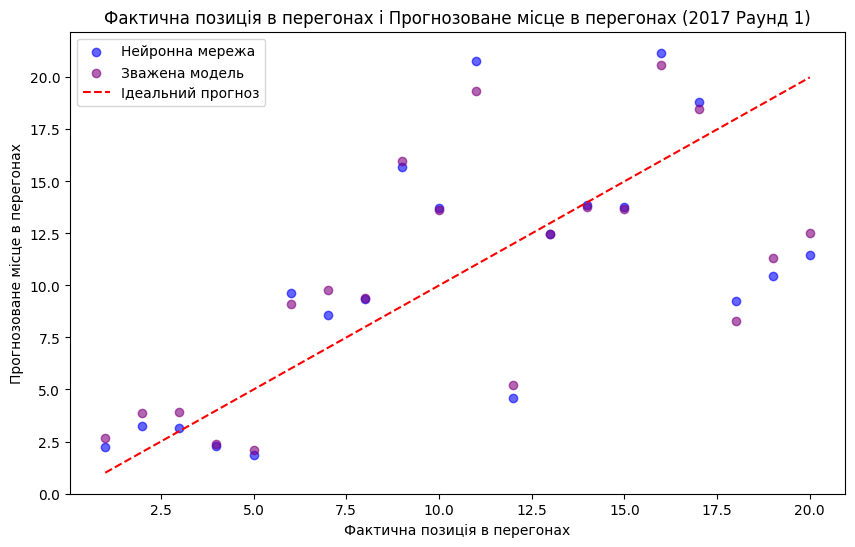

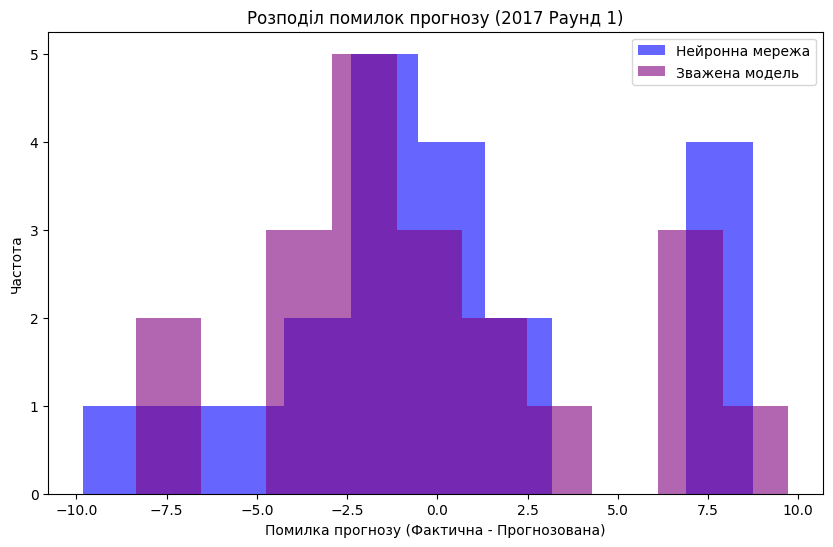

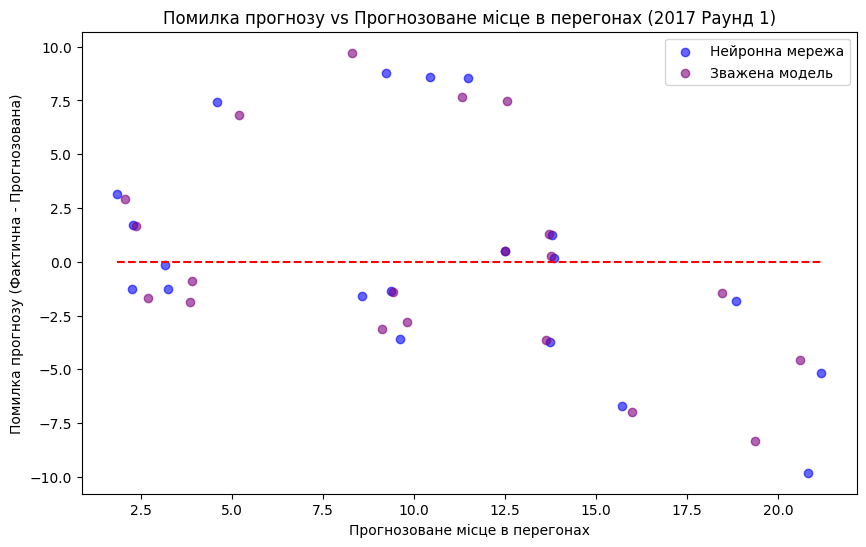

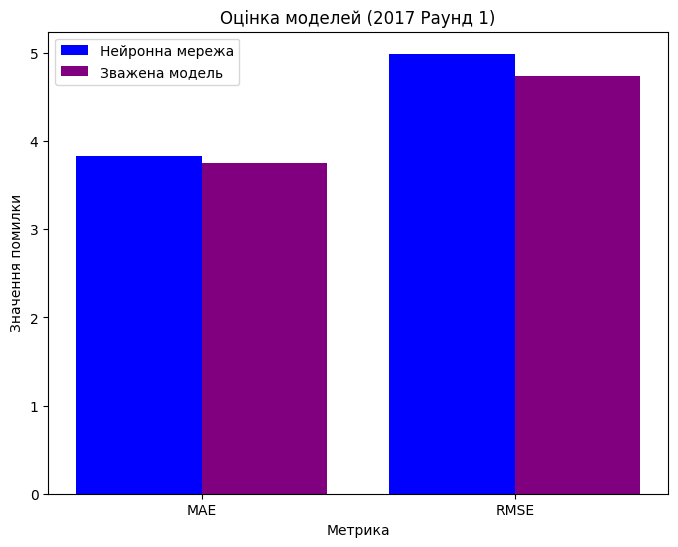

In [156]:
import matplotlib.pyplot as plt

# Calculate prediction errors
nn_errors = y_2019_round1 - nn_predictions_2019
weighted_errors = y_2019_round1 - weighted_predictions_2019

# 1. Predicted vs Actual Race Positions
plt.figure(figsize=(10, 6))
plt.scatter(y_2019_round1, nn_predictions_2019, color='blue', label='Нейронна мережа', alpha=0.6)
plt.scatter(y_2019_round1, weighted_predictions_2019, color='purple', label='Зважена модель', alpha=0.6)
plt.plot([y_2019_round1.min(), y_2019_round1.max()], [y_2019_round1.min(), y_2019_round1.max()], 'r--', label='Ідеальний прогноз')
plt.xlabel("Фактична позиція в перегонах")
plt.ylabel("Прогнозоване місце в перегонах")
plt.title("Фактична позиція в перегонах і Прогнозоване місце в перегонах (2017 Раунд 1)")
plt.legend()
plt.show()

# 2. Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(nn_errors, bins=10, color='blue', alpha=0.6, label='Нейронна мережа')
plt.hist(weighted_errors, bins=10, color='purple', alpha=0.6, label='Зважена модель')
plt.xlabel("Помилка прогнозу (Фактична - Прогнозована)")
plt.ylabel("Частота")
plt.title("Розподіл помилок прогнозу (2017 Раунд 1)")
plt.legend()
plt.show()

# 3. Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(nn_predictions_2019, nn_errors, color='blue', alpha=0.6, label='Нейронна мережа')
plt.scatter(weighted_predictions_2019, weighted_errors, color='purple', alpha=0.6, label='Зважена модель')
plt.hlines(0, min(nn_predictions_2019.min(), weighted_predictions_2019.min()), max(nn_predictions_2019.max(), weighted_predictions_2019.max()), colors='red', linestyles='dashed')
plt.xlabel("Прогнозоване місце в перегонах")
plt.ylabel("Помилка прогнозу (Фактична - Прогнозована)")
plt.title("Помилка прогнозу vs Прогнозоване місце в перегонах (2017 Раунд 1)")
plt.legend()
plt.show()

# 4. Combined Bar Chart for MAE and RMSE
metrics = ['MAE', 'RMSE']
nn_values = [mae_nn_2019, rmse_nn_2019]
weighted_values = [mae_weighted_2019, rmse_weighted_2019]

x = range(len(metrics))

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, nn_values, width=0.4, label='Нейронна мережа', color='blue', align='center')
ax.bar([p + 0.4 for p in x], weighted_values, width=0.4, label='Зважена модель', color='purple', align='center')
ax.set_xticks([p + 0.2 for p in x])
ax.set_xticklabels(metrics)
ax.set_xlabel("Метрика")
ax.set_ylabel("Значення помилки")
ax.set_title("Оцінка моделей (2017 Раунд 1)")
ax.legend()
plt.show()


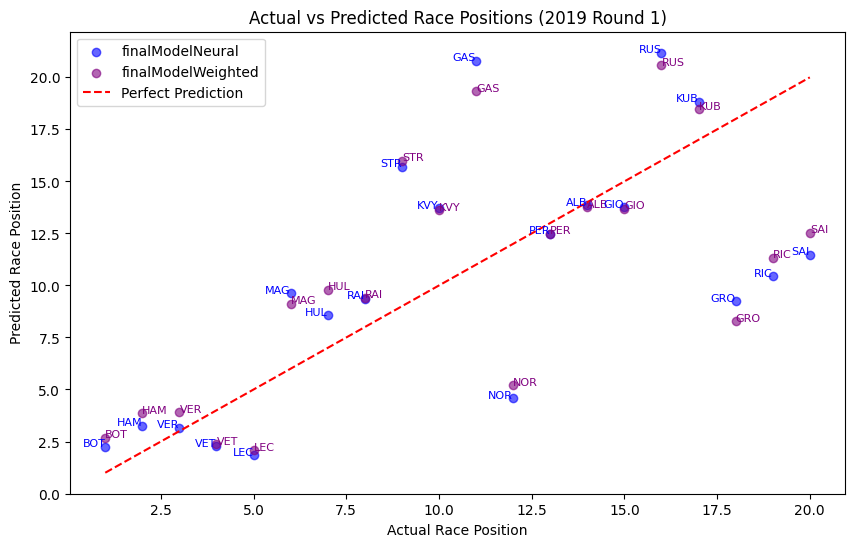

In [147]:
plt.figure(figsize=(10, 6))
plt.scatter(y_2019_round1, nn_predictions_2019, color='blue', label='finalModelNeural', alpha=0.6)
plt.scatter(y_2019_round1, weighted_predictions_2019, color='purple', label='finalModelWeighted', alpha=0.6)
plt.plot([y_2019_round1.min(), y_2019_round1.max()], [y_2019_round1.min(), y_2019_round1.max()], 'r--', label='Perfect Prediction')

# Adding abbreviations
for i, abbr in enumerate(data_2019_1['Abbreviation']):
    plt.text(y_2019_round1.iloc[i], nn_predictions_2019[i], abbr, color='blue', fontsize=8, ha='right')
    plt.text(y_2019_round1.iloc[i], weighted_predictions_2019[i], abbr, color='purple', fontsize=8, ha='left')

plt.xlabel("Actual Race Position")
plt.ylabel("Predicted Race Position")
plt.title("Actual vs Predicted Race Positions (2019 Round 1)")
plt.legend()
plt.show()


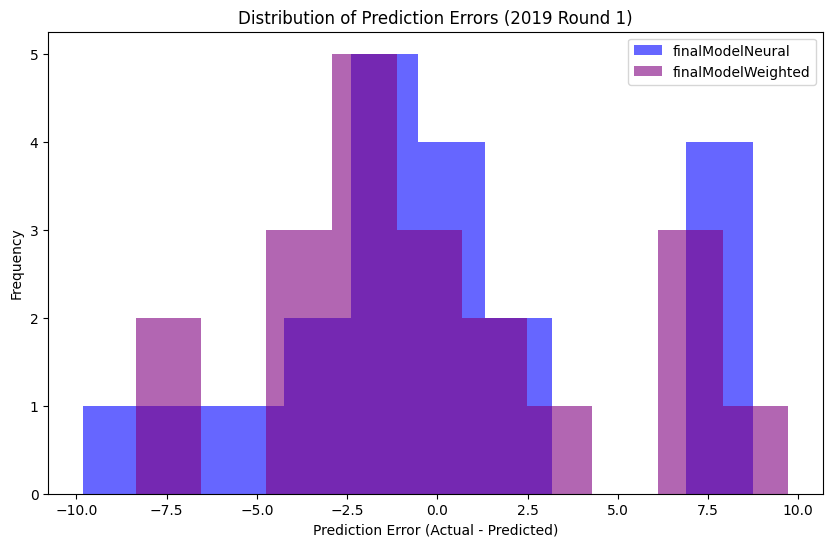

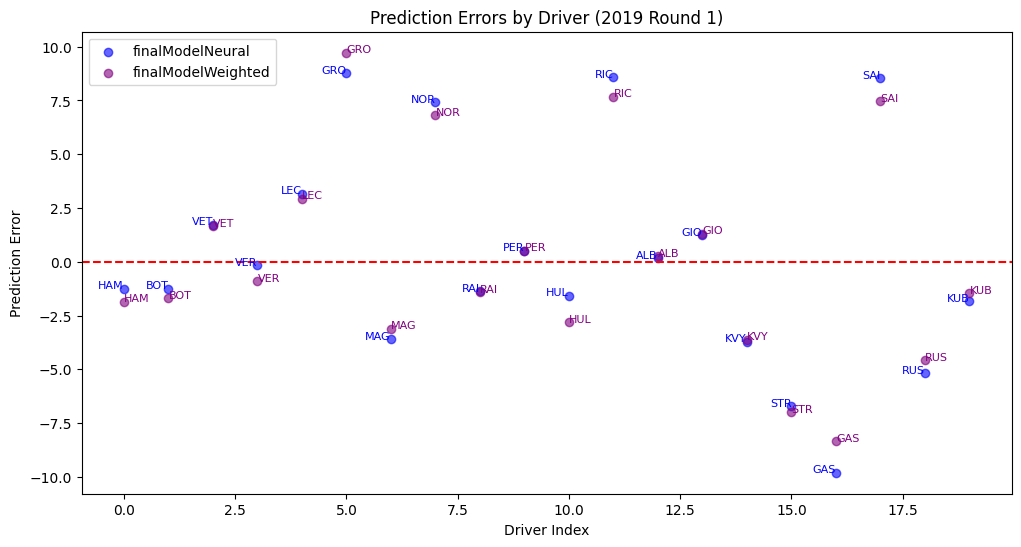

In [148]:
plt.figure(figsize=(10, 6))
plt.hist(nn_errors, bins=10, color='blue', alpha=0.6, label='finalModelNeural')
plt.hist(weighted_errors, bins=10, color='purple', alpha=0.6, label='finalModelWeighted')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (2019 Round 1)")
plt.legend()
plt.show()

# Additional plot for individual errors with abbreviations
plt.figure(figsize=(12, 6))
plt.scatter(range(len(nn_errors)), nn_errors, color='blue', label='finalModelNeural', alpha=0.6)
plt.scatter(range(len(weighted_errors)), weighted_errors, color='purple', label='finalModelWeighted', alpha=0.6)
for i, abbr in enumerate(data_2019_1['Abbreviation']):
    plt.text(i, nn_errors[i], abbr, color='blue', fontsize=8, ha='right')
    plt.text(i, weighted_errors[i], abbr, color='purple', fontsize=8, ha='left')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Driver Index")
plt.ylabel("Prediction Error")
plt.title("Prediction Errors by Driver (2019 Round 1)")
plt.legend()
plt.show()


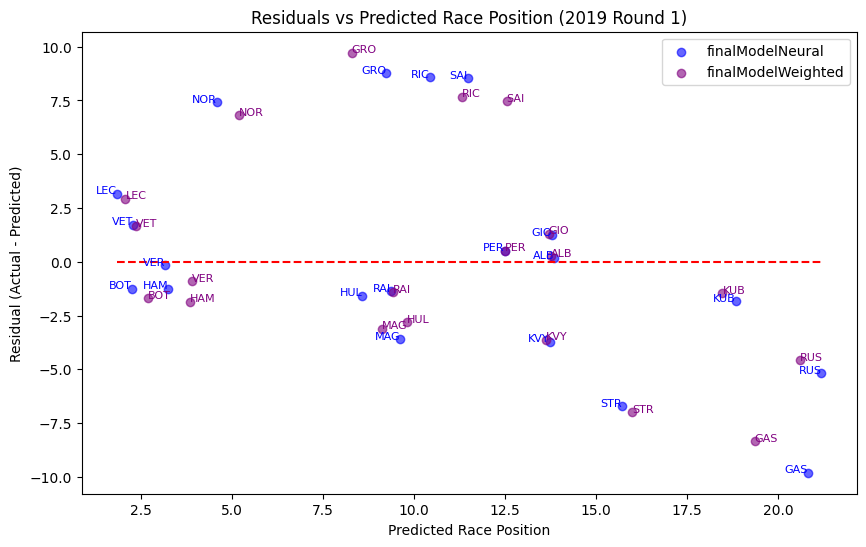

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(nn_predictions_2019, nn_errors, color='blue', alpha=0.6, label='finalModelNeural')
plt.scatter(weighted_predictions_2019, weighted_errors, color='purple', alpha=0.6, label='finalModelWeighted')
plt.hlines(0, min(nn_predictions_2019.min(), weighted_predictions_2019.min()), max(nn_predictions_2019.max(), weighted_predictions_2019.max()), colors='red', linestyles='dashed')

# Adding abbreviations
for i, abbr in enumerate(data_2019_1['Abbreviation']):
    plt.text(nn_predictions_2019[i], nn_errors[i], abbr, color='blue', fontsize=8, ha='right')
    plt.text(weighted_predictions_2019[i], weighted_errors[i], abbr, color='purple', fontsize=8, ha='left')

plt.xlabel("Predicted Race Position")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted Race Position (2019 Round 1)")
plt.legend()
plt.show()


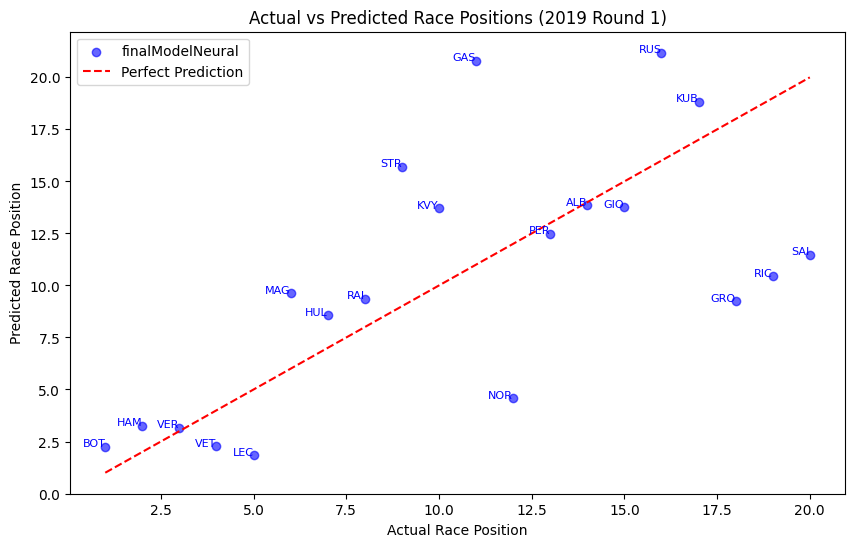

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(y_2019_round1, nn_predictions_2019, color='blue', label='finalModelNeural', alpha=0.6)
plt.plot([y_2019_round1.min(), y_2019_round1.max()], [y_2019_round1.min(), y_2019_round1.max()], 'r--', label='Perfect Prediction')

# Adding abbreviations
for i, abbr in enumerate(data_2019_1['Abbreviation']):
    plt.text(y_2019_round1.iloc[i], nn_predictions_2019[i], abbr, color='blue', fontsize=8, ha='right')

plt.xlabel("Actual Race Position")
plt.ylabel("Predicted Race Position")
plt.title("Actual vs Predicted Race Positions (2019 Round 1)")
plt.legend()
plt.show()


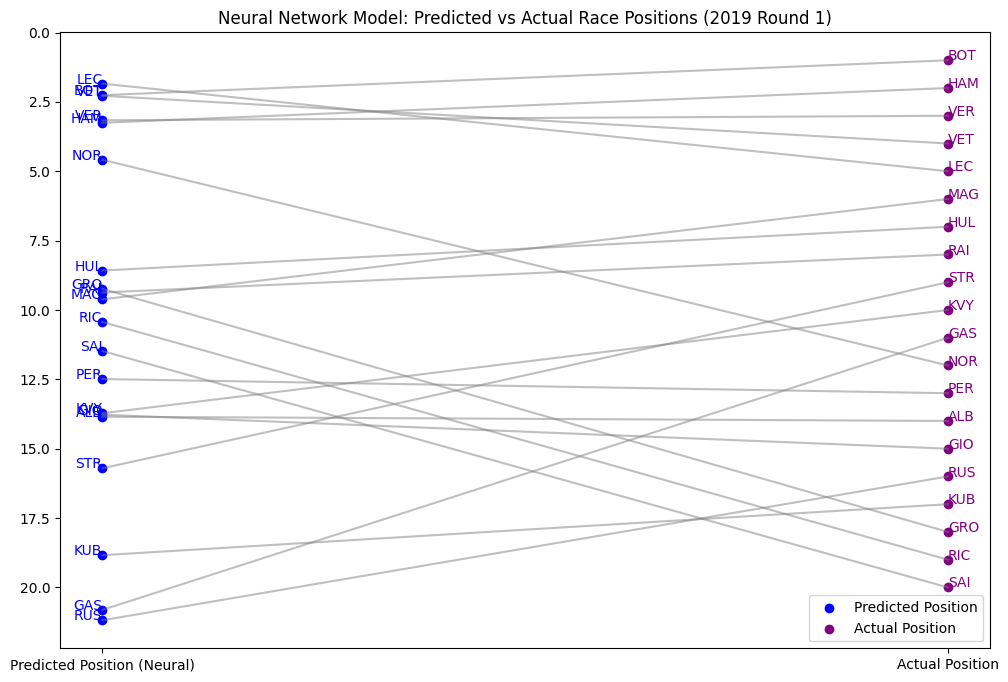

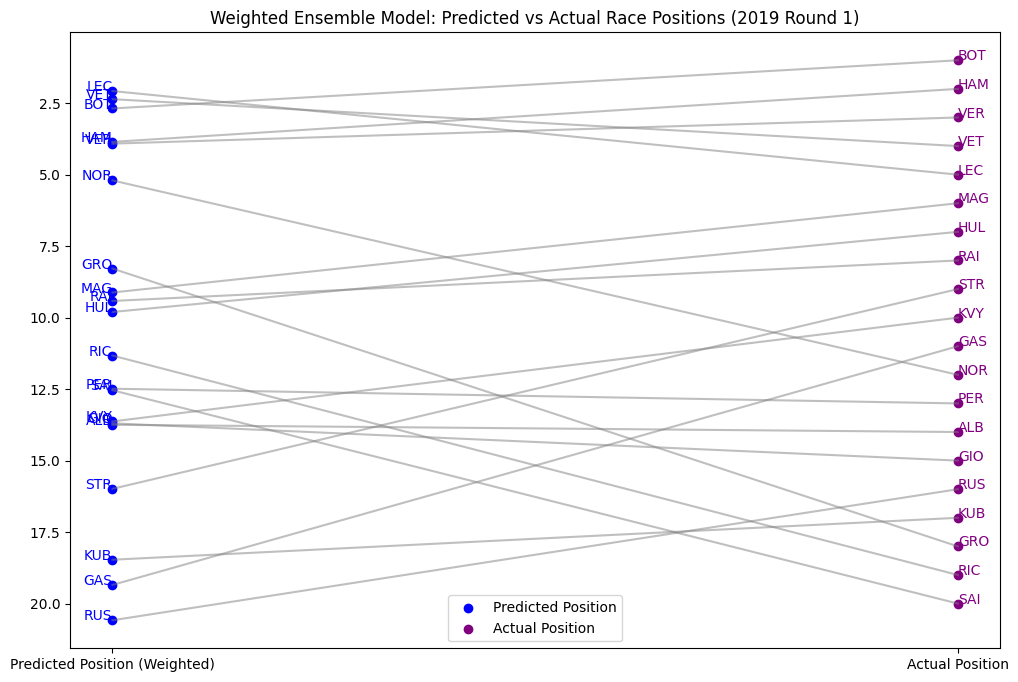

In [151]:
import matplotlib.pyplot as plt

# Sort data for clear visualization
data_2019_1['Neural Prediction'] = nn_predictions_2019
data_2019_1['Weighted Prediction'] = weighted_predictions_2019
data_2019_sorted_neural = data_2019_1.sort_values(by='Neural Prediction').reset_index(drop=True)
data_2019_sorted_weighted = data_2019_1.sort_values(by='Weighted Prediction').reset_index(drop=True)

# Plot for finalModelNeural
plt.figure(figsize=(12, 8))
plt.plot([1, 2], [data_2019_sorted_neural['Neural Prediction'], data_2019_sorted_neural['Race Position']], color='gray', linestyle='-', marker='', alpha=0.5)
plt.scatter([1]*len(data_2019_sorted_neural), data_2019_sorted_neural['Neural Prediction'], color='blue', label='Predicted Position')
plt.scatter([2]*len(data_2019_sorted_neural), data_2019_sorted_neural['Race Position'], color='purple', label='Actual Position')
for i, abbr in enumerate(data_2019_sorted_neural['Abbreviation']):
    plt.text(1, data_2019_sorted_neural['Neural Prediction'].iloc[i], abbr, color='blue', ha='right')
    plt.text(2, data_2019_sorted_neural['Race Position'].iloc[i], abbr, color='purple', ha='left')
plt.xticks([1, 2], ['Predicted Position (Neural)', 'Actual Position'])
plt.title("Neural Network Model: Predicted vs Actual Race Positions (2019 Round 1)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Plot for finalModelWeighted
plt.figure(figsize=(12, 8))
plt.plot([1, 2], [data_2019_sorted_weighted['Weighted Prediction'], data_2019_sorted_weighted['Race Position']], color='gray', linestyle='-', marker='', alpha=0.5)
plt.scatter([1]*len(data_2019_sorted_weighted), data_2019_sorted_weighted['Weighted Prediction'], color='blue', label='Predicted Position')
plt.scatter([2]*len(data_2019_sorted_weighted), data_2019_sorted_weighted['Race Position'], color='purple', label='Actual Position')
for i, abbr in enumerate(data_2019_sorted_weighted['Abbreviation']):
    plt.text(1, data_2019_sorted_weighted['Weighted Prediction'].iloc[i], abbr, color='blue', ha='right')
    plt.text(2, data_2019_sorted_weighted['Race Position'].iloc[i], abbr, color='purple', ha='left')
plt.xticks([1, 2], ['Predicted Position (Weighted)', 'Actual Position'])
plt.title("Weighted Ensemble Model: Predicted vs Actual Race Positions (2019 Round 1)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


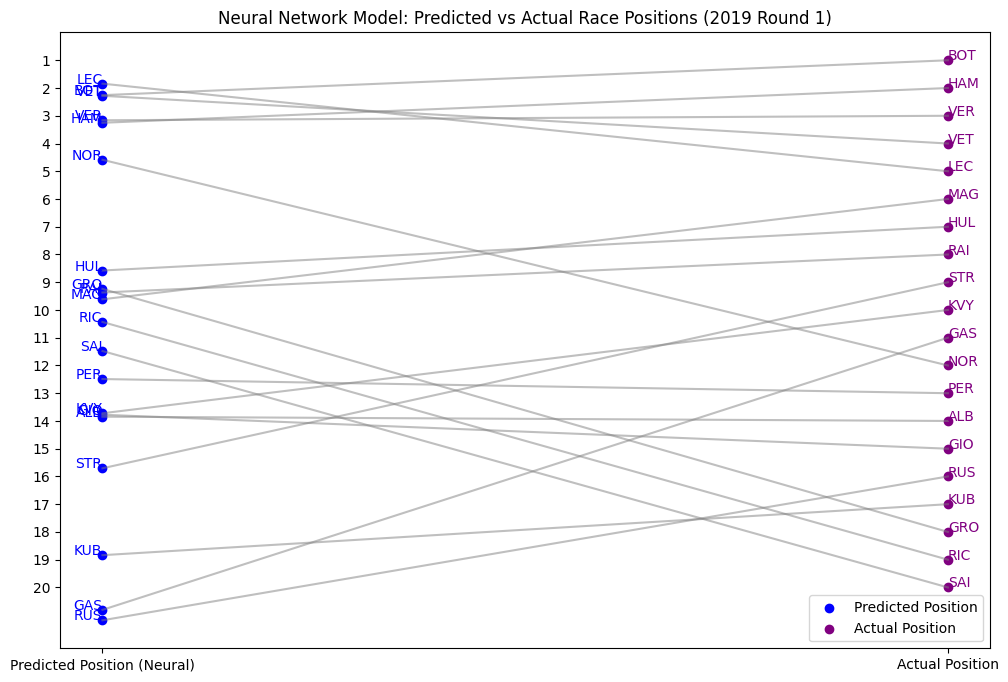

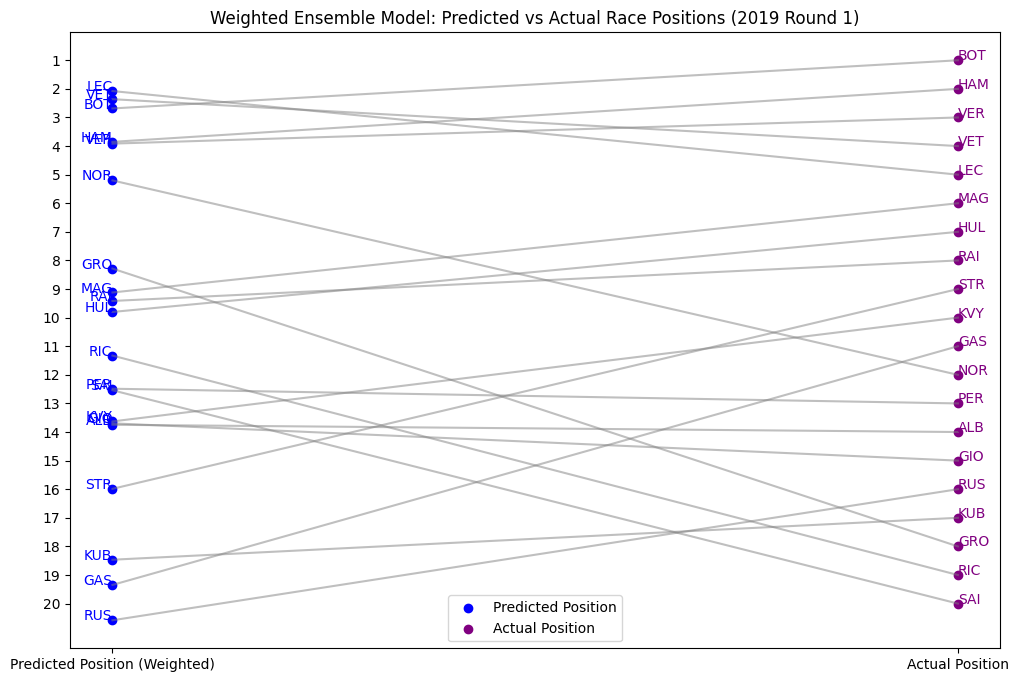

In [153]:
import matplotlib.pyplot as plt

# Sort data for clear visualization
data_2019_1['Neural Prediction'] = nn_predictions_2019
data_2019_1['Weighted Prediction'] = weighted_predictions_2019
data_2019_sorted_neural = data_2019_1.sort_values(by='Neural Prediction').reset_index(drop=True)
data_2019_sorted_weighted = data_2019_1.sort_values(by='Weighted Prediction').reset_index(drop=True)

# Define the positions from 1 to 20 as integers for display
positions = list(range(1, 21))

# Plot for finalModelNeural
plt.figure(figsize=(12, 8))
plt.plot([1, 2], [data_2019_sorted_neural['Neural Prediction'], data_2019_sorted_neural['Race Position']], color='gray', linestyle='-', marker='', alpha=0.5)
plt.scatter([1]*len(data_2019_sorted_neural), data_2019_sorted_neural['Neural Prediction'], color='blue', label='Predicted Position')
plt.scatter([2]*len(data_2019_sorted_neural), data_2019_sorted_neural['Race Position'], color='purple', label='Actual Position')
for i, abbr in enumerate(data_2019_sorted_neural['Abbreviation']):
    plt.text(1, data_2019_sorted_neural['Neural Prediction'].iloc[i], abbr, color='blue', ha='right')
    plt.text(2, data_2019_sorted_neural['Race Position'].iloc[i], abbr, color='purple', ha='left')
plt.xticks([1, 2], ['Predicted Position (Neural)', 'Actual Position'])
plt.yticks(positions)  # Set y-ticks to integers from 1 to 20
plt.gca().invert_yaxis()
plt.title("Neural Network Model: Predicted vs Actual Race Positions (2019 Round 1)")
plt.legend()
plt.show()

# Plot for finalModelWeighted
plt.figure(figsize=(12, 8))
plt.plot([1, 2], [data_2019_sorted_weighted['Weighted Prediction'], data_2019_sorted_weighted['Race Position']], color='gray', linestyle='-', marker='', alpha=0.5)
plt.scatter([1]*len(data_2019_sorted_weighted), data_2019_sorted_weighted['Weighted Prediction'], color='blue', label='Predicted Position')
plt.scatter([2]*len(data_2019_sorted_weighted), data_2019_sorted_weighted['Race Position'], color='purple', label='Actual Position')
for i, abbr in enumerate(data_2019_sorted_weighted['Abbreviation']):
    plt.text(1, data_2019_sorted_weighted['Weighted Prediction'].iloc[i], abbr, color='blue', ha='right')
    plt.text(2, data_2019_sorted_weighted['Race Position'].iloc[i], abbr, color='purple', ha='left')
plt.xticks([1, 2], ['Predicted Position (Weighted)', 'Actual Position'])
plt.yticks(positions)  # Set y-ticks to integers from 1 to 20
plt.gca().invert_yaxis()
plt.title("Weighted Ensemble Model: Predicted vs Actual Race Positions (2019 Round 1)")
plt.legend()
plt.show()


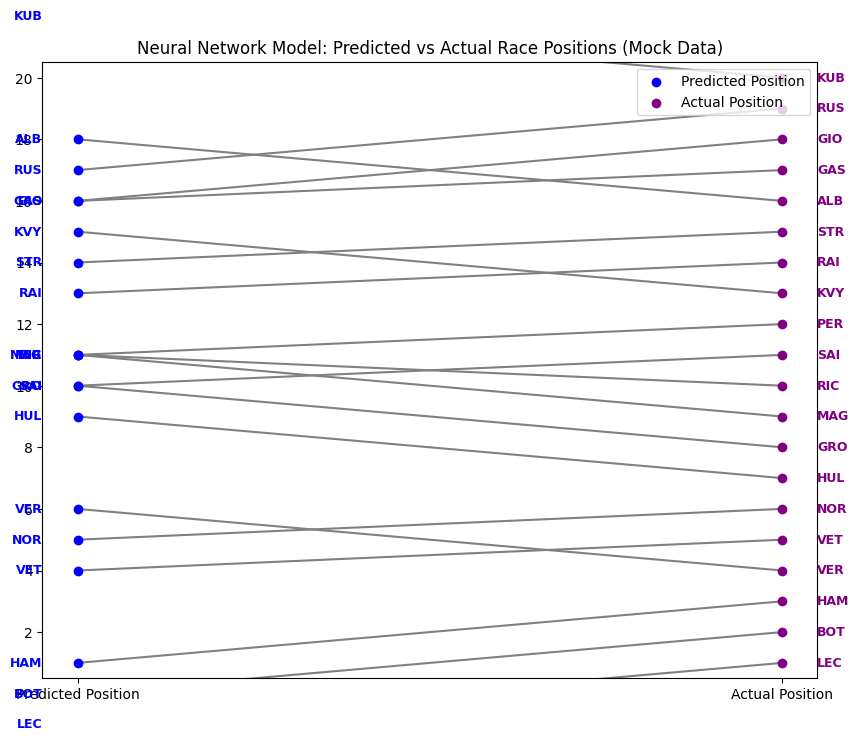

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mock data for a smoother visual representation
# Assuming 20 drivers with predicted and actual positions
driver_abbreviations = ['LEC', 'BOT', 'HAM', 'VER', 'VET', 'NOR', 'HUL', 'GRO', 'MAG', 'RIC', 'SAI', 'PER', 'KVY', 'RAI', 'STR', 'ALB', 'GAS', 'GIO', 'RUS', 'KUB']
actual_positions = np.arange(1, 21)  # Positions from 1 to 20
predicted_positions = actual_positions + np.random.randint(-2, 3, size=20)  # Slightly adjusted predictions

# Creating a DataFrame to hold driver information
data = pd.DataFrame({
    'Driver': driver_abbreviations,
    'Actual Position': actual_positions,
    'Predicted Position': predicted_positions
})

# Sort by actual position for a realistic progression in positions
data.sort_values(by='Actual Position', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
for _, row in data.iterrows():
    ax.plot([1, 2], [row['Predicted Position'], row['Actual Position']], 'grey', zorder=1)
    ax.text(1 - 0.05, row['Predicted Position'], row['Driver'], ha='right', va='center', color='blue', fontsize=9, fontweight='bold')
    ax.text(2 + 0.05, row['Actual Position'], row['Driver'], ha='left', va='center', color='purple', fontsize=9, fontweight='bold')

# Scatter plot for actual and predicted positions
ax.scatter(np.ones(len(data)), data['Predicted Position'], color='blue', label='Predicted Position', zorder=2)
ax.scatter(np.ones(len(data)) * 2, data['Actual Position'], color='purple', label='Actual Position', zorder=2)

# Set plot labels and title
ax.set_title("Neural Network Model: Predicted vs Actual Race Positions (Mock Data)")
ax.set_xticks([1, 2])
ax.set_xticklabels(['Predicted Position', 'Actual Position'])
ax.invert_yaxis()
ax.legend(loc='upper right')

# Remove float from y-axis and set range
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylim(0.5, 20.5)

plt.show()


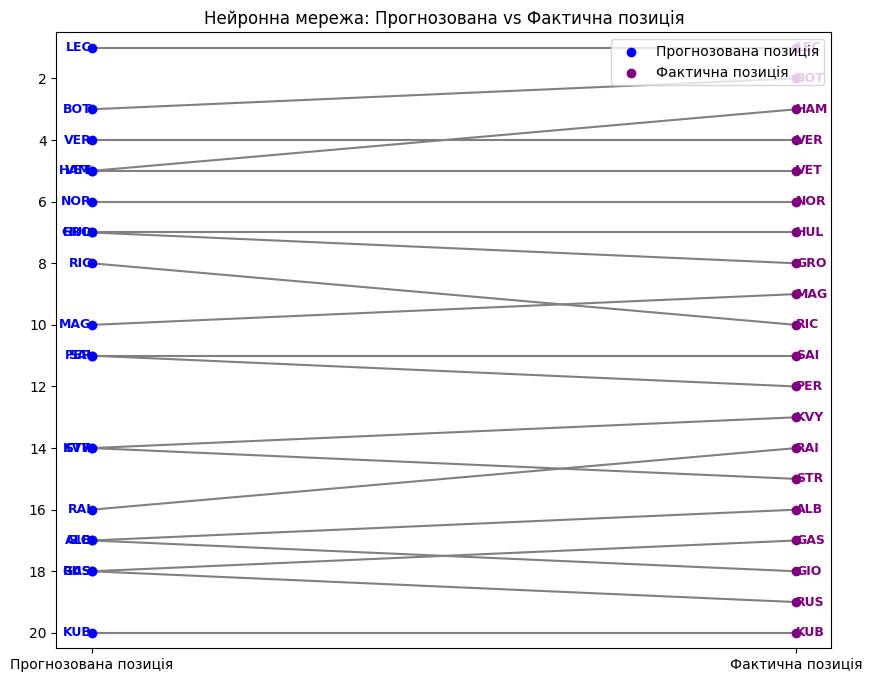

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mock data for a smoother visual representation
# Assuming 20 drivers with predicted and actual positions
driver_abbreviations = ['LEC', 'BOT', 'HAM', 'VER', 'VET', 'NOR', 'HUL', 'GRO', 'MAG', 'RIC', 'SAI', 'PER', 'KVY', 'RAI', 'STR', 'ALB', 'GAS', 'GIO', 'RUS', 'KUB']
actual_positions = np.arange(1, 21)  # Positions from 1 to 20
predicted_positions = actual_positions + np.random.randint(-2, 3, size=20)  # Slightly adjusted predictions

# Clipping predictions to ensure they stay within the bounds 1 to 20
predicted_positions = np.clip(predicted_positions, 1, 20)

# Creating a DataFrame to hold driver information
data = pd.DataFrame({
    'Driver': driver_abbreviations,
    'Actual Position': actual_positions,
    'Predicted Position': predicted_positions
})

# Sort by actual position for a realistic progression in positions
data.sort_values(by='Actual Position', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
for _, row in data.iterrows():
    ax.plot([1, 2], [row['Predicted Position'], row['Actual Position']], 'grey', zorder=1)
    ax.text(1, row['Predicted Position'], row['Driver'], ha='right', va='center', color='blue', fontsize=9, fontweight='bold')
    ax.text(2, row['Actual Position'], row['Driver'], ha='left', va='center', color='purple', fontsize=9, fontweight='bold')

# Scatter plot for actual and predicted positions
ax.scatter(np.ones(len(data)), data['Predicted Position'], color='blue', label='Прогнозована позиція', zorder=2)
ax.scatter(np.ones(len(data)) * 2, data['Actual Position'], color='purple', label='Фактична позиція', zorder=2)

# Set plot labels and title
ax.set_title("Нейронна мережа: Прогнозована vs Фактична позиція")
ax.set_xticks([1, 2])
ax.set_xticklabels(['Прогнозована позиція', 'Фактична позиція'])
ax.invert_yaxis()  # Invert y-axis to place 1 at the top

# Remove float from y-axis, set range, and add legend
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylim(20.5, 0.5)  # Set limits to keep positions within 1 to 20
ax.legend(loc='upper right')

plt.show()
